# Test Data Trend Analysis

In [1]:
# IMPORTANT: to run any lines of code in this application, please run all lines of code from section 1.1, 
# unless stated otherwise in the block of code

### Installation of Libraries

In [6]:
# If these imports have already been made once, they may be ignored
!pip install pandasql
!pip install plotly==5.14.1
!pip install graphviz
!pip install numpy --upgrade --user## Pre-requisites to Run Program

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Importing of Relevant Libraries

In [37]:
# These imports must be made every time the kernel is launched

# Imports necessary for Utilization of Dataframe/Visualization
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pandas as pd
from pandasql import sqldf
import plotly.express as px

# K-Means Clustering Necessary Imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# Random Forest Necessary Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Keras (Neural Network) Necessary Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Results Necessary Inputs
import operator

### Defining Necessary Functions

#### Pre-Processing Data Functions Part 1

In [38]:
def obtainFullPatientInfo():
    clinicalPatientDF = pd.read_csv("../Test-Data/data_clinical_patient.txt",delimiter="\t", header = 4)
    clinicalSampleDF = pd.read_csv("../Test-Data/data_clinical_sample.txt",delimiter="\t", header = 4)
    
    fullPatientInfo = pd.merge(clinicalPatientDF, clinicalSampleDF, how="outer", on=["PATIENT_ID", "PATIENT_ID"])
    
    # The following is necessary to search for the next line, as the .str.contains method will not work when a DF has empty cells
    fullPatientInfo[['MSI_STATUS']] = fullPatientInfo[['MSI_STATUS']].fillna('Unknown')
    fullPatientInfo[['FIRST_SITE_OF_METS']] = fullPatientInfo[['FIRST_SITE_OF_METS']].fillna('Not Provided')
    fullPatientInfo[['METASTATIC_BIOPSY_SITE']] = fullPatientInfo[['METASTATIC_BIOPSY_SITE']].fillna('Not Provided')
    
    return fullPatientInfo

#### Data Visualization Functions

In [39]:
def group_and_visualize_plots(currentValues):
    grouped = resultUnchanged.groupby(currentValues)
    arrayForm = resultUnchanged[currentValues]    
    allCombos = list(arrayForm.groupby(currentValues).groups)
    
    for i in allCombos:
        df = grouped.get_group(i)
        fig = px.scatter(df, x="AGE_AT_DIAGNOSIS", y="OS_MONTHS", 
                         color = df[currentValues].apply(tuple, axis=1), 
                         hover_data=["PATIENT_ID", "SAMPLE_ID"])
        fig.show()

#### K-Means Clustering Functions

In [40]:
# Function returns a Pandas Dataframe that merges the information from the existing UnchangedData frame and adds the
# corresponding cluster from the graph for each datapoint, allowing one to then compare similar datapoints
def display_and_visualize_cluster(numClusters, X):
    # the model is first train based on the input (the desired number of clusters) and data provided
    kmeans = KMeans(n_clusters = numClusters)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    
    # prints all of the points in the dataframe that are not empty
    plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
    
    # prints the clusters on the plot
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
    
    
    # the data is exported and tracked back to the original dataset so each datapoint in a cluster can be analyzed
    Y = y_kmeans[:, np.newaxis]
    
    # what first needs to be done is each datapoint in the cluster dataset (index maps to index of X value) 
    # needs to be connected with its corresponding X value, which can be done through a horizontal join 
    combinedArrays = np.hstack((X, Y))
    lastColumnName = 'CLUSTER_NUMBER_' + str(numClusters)
    combinedDF = pd.DataFrame(combinedArrays, columns = ['AGE_AT_DIAGNOSIS','OS_MONTHS', lastColumnName])
    
    # prevents the join function from creating more cells than necessary
    noDups = combinedDF.drop_duplicates()
    
    
    # since an outer join is completed, where duplicate rows would result in a table larger than earlier, 
    # we first eliminate duplicates to preserve the order and size of resultUnchanged 
    new_df = pd.merge(resultUnchanged, noDups,  how='left', 
                      left_on=['AGE_AT_DIAGNOSIS','OS_MONTHS'], right_on = ['AGE_AT_DIAGNOSIS','OS_MONTHS'])
    
    return new_df

#### Pre-Processing Data Functions Part 2

In [41]:
def createManualOneHotEncoding(currentColumnToOneHotEncode, currentColumnName, splittingValue):   
    # Creates a list of all unique values within a column; converts NaN to a string representation
    updatedArray = currentColumnToOneHotEncode.unique()
    for i in range(len(updatedArray)):
        if type(updatedArray[i]) != str:
            updatedArray[i] = 'Not available'
    
    # Previously, the list of 'all unique values' contained elements that were of the following (example) format: 
        # Crizotinib(MET Amplification);Dabrafenib,Vemurafenib+Cobimetinib,Trametinib,Trametinib+Dabrafenib,Vemurafenib(BRAF p.V600E)
    # Instead of registering this as a unique value, the plan is to split it into 2 values, which have their own unique binary test
    setOfValues = set([])
    for i in updatedArray:
        currentString = i
        startPosition = 0
        colonPosition = 0
        while splittingValue in currentString:
            # Finds first instance of ; in the string, and splits the current string to 2 strings, each of which does not contain the currently found ;
            colonPosition = currentString.find(splittingValue)        
            substringToAdd = currentString[startPosition : colonPosition]
            currentString = currentString[(colonPosition + 1) : (len(currentString))]
            # prevents a substring of length 0 from being added to the set of all possible values
            if len(substringToAdd) > 1:
                setOfValues.add(substringToAdd)
            startPosition = colonPosition + 1
        setOfValues.add(currentString)
    
    # Since the columns argument cannot unhash a set, it is first converted into a list; this list is later used to append the manual One Hot Encoding
    valuesToCheck = list(setOfValues)
    df = pd.DataFrame(columns=valuesToCheck)
    
    # The current column's NaN values are first converted to a string, and then the manual One Hot Encoding for each row is created
    currentColumnToOneHotEncode = currentColumnToOneHotEncode.fillna('Not available')
    for i in currentColumnToOneHotEncode:
        currentDict = {}
        for j in valuesToCheck:
            if j in i:
                currentDict[j] = 1
            else:
                currentDict[j] = 0
        df = df.append(currentDict, ignore_index=True)
    
    for i in df.columns:
        currentName = i
        newName = currentColumnName + ': ' + currentName
        df = df.rename(columns={currentName:newName})
    return df

In [42]:
def containerToEncode(container, columnsNecessaryForManualEncoding):   
    for i in columnsNecessaryForManualEncoding:
        oneHotEncodedColumn = createManualOneHotEncoding(container[i], i, ';')
        container = pd.concat([container, oneHotEncodedColumn], axis=1)
        del container[i]
    return container

In [43]:
def prepareContainerForAnalysis(containerToModify):
    columnsToRemove = []
    for col in containerToModify.columns:
        if containerToModify[col].dtype == 'float64' or containerToModify[col].dtype == 'int64':
            containerToModify[[col]] = containerToModify[[col]].fillna(0)
        else:
            stringToAdd = 'Not_Provided'
            containerToModify[[col]] = containerToModify[[col]].fillna(stringToAdd)
            oneHotEncodedColumns = pd.get_dummies(containerToModify[col])
            prefixToAdd = col + '_'
            for i in oneHotEncodedColumns.columns:
                newColumnName = str(prefixToAdd) + str(i)
                newColumnName = newColumnName.upper()
                oneHotEncodedColumns.rename(columns = {i:newColumnName}, inplace = True)
            del containerToModify[col]
            containerToModify = pd.concat([containerToModify, oneHotEncodedColumns], axis=1)
    return containerToModify

#### Random Forest Classifier Functions

In [44]:
def averageSuccessRateCLF(numberIterations, X_train, y_train, X_test, y_test):
    containerPredictionAccuracies = []
    
    for i in range(numberIterations):
        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_test)
        
        accuracyCurrentModel = calculatePercentAccuracyModel(y_pred, y_test)
        containerPredictionAccuracies.append(accuracyCurrentModel)
        
    averagePercentAccuracy = (sum(containerPredictionAccuracies))/numberIterations
    return averagePercentAccuracy

#### Artificial Neural Network Functions

In [45]:
# Makes a neural network with the specified dimensions, where each hidden layer besides
# the last one uses a relu activation function and the last one uses a sigmoid activation 
# function. Uses a adam optimizer and mean_squared_error loss function to learn and create
# a raw array with predicted values; these values must be rounded for usable prediction
def generateRawModelPrediction(neuralNetworkDimensions, X_train, y_train, X_test):
    inputs = Input(shape=X_train.shape[1])
    
    x = Dense(neuralNetworkDimensions[0], activation="relu")(inputs)
    i = 1
    while i < (len(neuralNetworkDimensions) - 1):
        x = Dense(i, activation="relu")(x)
        i += 1
    x = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs, x)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    # train the model
    print("[INFO] training model...")
    model.fit(X_train, y_train, epochs=150, batch_size=10, verbose=0)
    
    _, accuracy = model.evaluate(X_train, y_train)
    print('Accuracy: %.2f' % (accuracy*100))
    
    # make predictions on the testing data
    print("[INFO] predicting vital status of patients...")
    testPredictions = model.predict(X_test)
    
    return testPredictions

In [46]:
# Turns an array that has decimal values between 0 and 1
# into either 0 or 1 and returns the rounded array
def roundArray(rawPredictionArray):
    predictionsRounded = []
    for i in rawPredictionArray:
        if i < 0.5:
            predictionsRounded.append(math.floor(i))
        else:
            predictionsRounded.append(math.ceil(i))
    return predictionsRounded

In [47]:
def calculatePercentAccuracyModel(predictionArray, y_test):
    totalComparisons = 0
    correctComparisons = 0
    
    for i in range(len(predictionArray)):
        totalComparisons += 1
        if predictionArray[i] == y_test.iloc[i]:
            correctComparisons += 1
    
    percentageCorrect = correctComparisons/totalComparisons
    return percentageCorrect

In [48]:
def testModelForAccuracy(neuralNetworkDimensions, X_train, y_train, X_test, y_test):
    currentPredictions = generateRawModelPrediction(neuralNetworkDimensions, X_train, y_train, X_test)
    modelPredictions = roundArray(currentPredictions)
    accuracyCurrentModel = calculatePercentAccuracyModel(modelPredictions, y_test3)
    print(accuracyCurrentModel)

In [49]:
def averageSuccessRateModel(numberIterations, neuralNetworkDimensions, X_train, y_train, X_test, y_test):
    containerPredictionAccuracies = []
    
    for i in range(numberIterations):
        currentPredictions = generateRawModelPrediction(neuralNetworkDimensions, X_train, y_train, X_test)
        modelPredictions = roundArray(currentPredictions)
        accuracyCurrentModel = calculatePercentAccuracyModel(modelPredictions, y_test3)
        
        containerPredictionAccuracies.append(accuracyCurrentModel)
        
    averagePercentAccuracy = (sum(containerPredictionAccuracies))/numberIterations
    return averagePercentAccuracy

#### Model Verification Functions

In [50]:
# Tests the consistency of an ANN by building an elaborate confusion matrix. The model runs numberIterations
# number of times, where the index of the current row is put into 1 of 4 sets, with titles established in the 
# elaborate_confusion_matrix_columns container. At the end, the model sees which values are correct 100% of 
# the time and which end up with either false positive/negative values. 
def testConsistencyModel(numberIterations, neuralNetworkDimensions, X_train, y_train, X_test, y_test):
    # Establishes the standard columns for a confusion matrix
    elaborate_confusion_matrix_columns = ['True Positive', 'False Positive', 'True Negative', 'False Negative']
    
    # Initializes a DF that will hold 4 binary values, with each value indicating whether the value was 
    # always correct, or whether it was not always correct
    elaborate_confusion_matrix = pd.DataFrame(columns=elaborate_confusion_matrix_columns)
    
    true_positive = set()
    false_positive = set()
    true_negative = set()
    false_negative = set()
    
    containerPredictionAccuracies = []
    for i in range(numberIterations):
        currentPredictions = generateRawModelPrediction(neuralNetworkDimensions, X_train, y_train, X_test)
        modelPredictions = roundArray(currentPredictions)
        for j in range(len(modelPredictions)):
            print(modelPredictions[j], y_test.iloc[j])
            if modelPredictions[j] == y_test.iloc[j]:
                if modelPredictions[j] == 0:
                    true_negative.add(j)
                    #print('TN', j)
                else:
                    true_positive.add(j)
                    #print('TP', j)
            else:
                if modelPredictions[j] == 0:
                    false_negative.add(j)
                    #print('FN', j)
                else:
                    false_positive.add(j)
                    #print('FP', j)
        accuracyCurrentModel = calculatePercentAccuracyModel(modelPredictions, y_test)
        containerPredictionAccuracies.append(accuracyCurrentModel)
        
    averagePercentAccuracy = (sum(containerPredictionAccuracies))/numberIterations
    print(averagePercentAccuracy)
    
    for i in range(len(modelPredictions)):
        default_entry = {'True Positive' : 0, 'False Positive' : 0, 'True Negative' : 0, 'False Negative' : 0}
        if i in true_positive:
            default_entry['True Positive'] = 1
        if i in false_positive:
            default_entry['False Positive'] = 1
        if i in true_negative:
            default_entry['True Negative'] = 1
        if i in false_negative:
            default_entry['False Negative'] = 1
            
        elaborate_confusion_matrix = elaborate_confusion_matrix.append(default_entry, ignore_index=True)
    
    return elaborate_confusion_matrix

In [51]:
# Tests the consistency of a Random Forest Classifer Model by building an elaborate confusion matrix. The model runs 
# numberIterations number of times, where the index of the current row is put into 1 of 4 sets, with titles established 
# in the elaborate_confusion_matrix_columns container. At the end, the model sees which values are correct 100% of the 
# time and which end up with either false positive/negative values. 
def testConsistencyCLF(numberIterations, X_train, y_train, X_test, y_test):
    # Establishes the standard columns for a confusion matrix
    elaborate_confusion_matrix_columns = ['True Positive', 'False Positive', 'True Negative', 'False Negative']
    
    # Initializes a DF that will hold 4 binary values, with each value indicating whether the value was always correct, or whether it was not always correct
    elaborate_confusion_matrix = pd.DataFrame(columns=elaborate_confusion_matrix_columns)
    
    true_positive = set()
    false_positive = set()
    true_negative = set()
    false_negative = set()
    
    containerPredictionAccuracies = []
    for i in range(numberIterations):
        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        for j in range(len(y_pred)):
            #print(y_pred[j], y_test.iloc[j])
            if y_pred[j] == y_test.iloc[j]:
                if y_pred[j] == 0:
                    true_negative.add(j)
                    #print('TN', j)
                else:
                    true_positive.add(j)
                    #print('TP', j)
            else:
                if y_pred[j] == 0:
                    false_negative.add(j)
                    #print('FN', j)
                else:
                    false_positive.add(j)
                    #print('FP', j)
        accuracyCurrentModel = calculatePercentAccuracyModel(y_pred, y_test)
        containerPredictionAccuracies.append(accuracyCurrentModel)
        
    averagePercentAccuracy = (sum(containerPredictionAccuracies))/numberIterations
    print(averagePercentAccuracy)
    
    for i in range(len(y_pred)):
        default_entry = {'True Positive' : 0, 'False Positive' : 0, 'True Negative' : 0, 'False Negative' : 0}
        if i in true_positive:
            default_entry['True Positive'] = 1
        if i in false_positive:
            default_entry['False Positive'] = 1
        if i in true_negative:
            default_entry['True Negative'] = 1
        if i in false_negative:
            default_entry['False Negative'] = 1
            
        elaborate_confusion_matrix = elaborate_confusion_matrix.append(default_entry, ignore_index=True)
    
    return elaborate_confusion_matrix

#### Results Functions

In [76]:
def mostImportantFeaturesCLF(numberIterations, X_train, y_train, X_test, y_test):
    containerPredictionAccuracies = []
    
    featureImportance = []
    for i in X_train.columns:
        featureImportance.append(list())
    
    for i in range(numberIterations):
        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_test)
        
        for z in range(len(clf.feature_importances_)):
            featureImportance[z].append(clf.feature_importances_[z])
        
        accuracyCurrentModel = calculatePercentAccuracyModel(y_pred, y_test)
        containerPredictionAccuracies.append(accuracyCurrentModel)
    
    allFeatures = {}
    for i in range(len(featureImportance)):
        total = sum(featureImportance[i])
        valueToAdd = (total/(len(featureImportance[i])))
        allFeatures[X_train.columns[i]] = valueToAdd      
    
    sortedFeaturesDesc = dict(sorted(allFeatures.items(), key=operator.itemgetter(1),reverse=True))
    return sortedFeaturesDesc

## Datasets

In [17]:
#Patient Identifier	Age at Diagnosis	Sex	Patient's Vital Status	Overall Survival Status	Overall Survival (Months)	OS Months (Additonal Data)	Patient Tumor Grade
#Identifier to uniquely specify a patient.	Age at Diagnosis	Sex	The survival state of the person.	Overall patient survival status.	Overall survival in months since initial diagonosis.	OS Months (Additonal Data)	Patient Tumor Grade
#STRING	NUMBER	STRING	STRING	STRING	NUMBER	NUMBER	STRING
#1	1	1	1	9	1	1	1

clinicalPatientDF = pd.read_csv("../Test-Data/data_clinical_patient.txt",delimiter="\t", header = 4)

In [80]:
clinicalPatientDF

PATIENT_ID  AGE_AT_DIAGNOSIS     SEX VITAL_STATUS   OS_STATUS  OS_MONTHS  \
0     P-0000119                67  Female     Deceased  1:DECEASED      27.37   
1     P-0000241                49  Female     Deceased  1:DECEASED      24.00   
2     P-0000493                24    Male     Deceased  1:DECEASED      23.87   
3     P-0000511                39  Female     Deceased  1:DECEASED      23.27   
4     P-0000520                64    Male       Living    0:LIVING      41.50   
...         ...               ...     ...          ...         ...        ...   
1094  P-0014252                59    Male       Living    0:LIVING      55.37   
1095  P-0014258                69    Male     Deceased  1:DECEASED       9.97   
1096  P-0014296                46  Female       Living    0:LIVING      12.07   
1097  P-0014404                62  Female       Living    0:LIVING        NaN   
1098  P-0014415                49    Male       Living    0:LIVING      24.10   

      OS_MONTHS_ADDITIONAL    PATIENT_GRADE  
0                      NaN         Mod_Diff  
1                      NaN  Mod-Poorly-Diff  
2                      NaN              NaN  
3                      NaN      Poorly-Diff  
4                      NaN  Mod-Poorly-Diff  
...                    ...              ...  
1094                   NaN         Mod_Diff  
1095                   NaN  Mod-Poorly-Diff  
1096                   NaN              NaN  
1097                 28.23      Poorly-Diff  
1098                   NaN         Mod_Diff  

[1099 rows x 8 columns]

In [81]:
#Patient Identifier	Sample Identifier	Chemo Exposure of sequenced specimen	Tumor Sample Histology	MSI Status	Oncotree Code	Sample Type	Primary Tumor Site	Metastatic Biopsy Site	Primary Tumor Location	Gene Panel	Stage At Diagnosis	Molecular Subtype	MSI Score	mCRC Type	Specimen Type	Metastasectomy	Metastasectomy Site	TIme to Metastasis Months	Time from Met Dx to Sequencing	First Site of Metastasis	Metastases Site First: Liver	Metastases Site First: Ln	Metastases Site First: Lung	Metastases Site First: Pelvis	Metastases Site First: Brain	Metastases Site First: Bone	Metastases Site First: Peritoneum, omentum, abdomen	Metastases Site First: Gynecological	Other Metastasis Sites	Cancer Type	Cancer Type Detailed	Somatic Status	TMB (nonsynonymous)
#Identifier to uniquely specify a patient.	A unique sample identifier.	Chemo Exposure of sequenced specimen	Tumor Sample Histology	MSI status.	Oncotree Code	The type of sample (i.e., normal, primary, met, recurrence).	Text term to describe the organ sub-division in an individual with cancer.	Metastatic Biopsy Site	Primary Tumor Location	Gene panel.	Stage At Diagnosis	Molecular subtype.	MSI Score	mCRC Type	The broad cancer phenotype and site information values for a sample to be processed.	Metastasectomy	Metastasectomy Site	TIme to Metastasis Months	Time from Met Dx to Sequencing	First Site of Metastasis	Metastases Site First: Liver	Metastases Site First: Ln	Metastases Site First: Lung	Metastases Site First: Pelvis	Metastases Site First: Brain	Metastases Site First: Bone	Metastases Site First: Peritoneum, omentum, abdomen	Metastases Site First: Gynecological	Other Metastasis Sites Description	Cancer Type	Cancer Type Detailed	Somatic Status	TMB (nonsynonymous)
#STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	NUMBER	STRING	STRING	STRING	STRING	NUMBER	NUMBER	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	NUMBER
#1	1	1	1	1	1	9	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1

clinicalSampleDF = pd.read_csv("../Test-Data/data_clinical_sample.txt",delimiter="\t", header = 4)

In [82]:
clinicalSampleDF

PATIENT_ID          SAMPLE_ID CHEMO_EXP_SEQ_SPECIMEN  \
0     P-0000119  P-0000119-T01-IM3                    Yes   
1     P-0000241  P-0000241-T01-IM3                    Yes   
2     P-0000493  P-0000493-T01-IM3                    Yes   
3     P-0000511  P-0000511-T01-IM3                    Yes   
4     P-0000520  P-0000520-T01-IM3                     No   
...         ...                ...                    ...   
1129  P-0014252  P-0014252-T01-IM6                    Yes   
1130  P-0014258  P-0014258-T01-IM6                     No   
1131  P-0014296  P-0014296-T01-IM6                     No   
1132  P-0014404  P-0014404-T01-IM6                     No   
1133  P-0014415  P-0014415-T01-IM6                    Yes   

     TUMOR_SAMPLE_HISTOLOGY MSI_STATUS ONCOTREE_CODE SAMPLE_TYPE  \
0              Conventional        NaN      COADREAD  Metastasis   
1              Conventional        MSS      COADREAD  Metastasis   
2                       NaN        NaN      COADREAD  Metastasis   
3                       PDC        MSS      COADREAD  Metastasis   
4              Conventional        MSS      COADREAD     Primary   
...                     ...        ...           ...         ...   
1129           Conventional        MSS      COADREAD  Metastasis   
1130           Conventional        NaN      COADREAD     Primary   
1131                    NaN        MSS      COADREAD  Metastasis   
1132       Signet_Ring_Cell        MSI      COADREAD     Primary   
1133           Conventional        MSS      COADREAD     Primary   

         PRIMARY_SITE METASTATIC_BIOPSY_SITE PRIMARY_TUMOR_LOCATION  ...  \
0               Cecum                  Ovary                  Right  ...   
1     Ascending Colon             Peritoneum                  Right  ...   
2       Sigmoid Colon                  Liver                   Left  ...   
3       Sigmoid Colon             Chest Wall                   Left  ...   
4               Cecum                    NaN                  Right  ...   
...               ...                    ...                    ...  ...   
1129            Cecum                  Liver                  Right  ...   
1130    Sigmoid Colon                    NaN                   Left  ...   
1131    Sigmoid Colon             Skull base                   Left  ...   
1132     Rectosigmoid                    NaN                   Left  ...   
1133     Rectosigmoid                    NaN                   Left  ...   

     METASTASES_SITE_FIRST_PELVIS METASTASES_SITE_FIRST_BRAIN  \
0                               0                           0   
1                               0                           0   
2                               0                           0   
3                               0                           0   
4                               0                           0   
...                           ...                         ...   
1129                            0                           0   
1130                            0                           0   
1131                            0                           1   
1132                            0                           0   
1133                            0                           0   

     METASTASES_SITE_FIRST_BONE  \
0                             0   
1                             0   
2                             0   
3                             0   
4                             0   
...                         ...   
1129                          0   
1130                          0   
1131                          0   
1132                          0   
1133                          0   

      METASTASES_SITE_FIRST_PERITONEUM_OMENTUM_ABDOMEN  \
0                                                    1   
1                                                    0   
2                                                    0   
3                                                    1   
4                                                 

In [60]:
#Patient Identifier	Sample Identifier	Chemo Exposure of sequenced specimen	Tumor Sample Histology	MSI Status	Oncotree Code	Sample Type	Primary Tumor Site	Metastatic Biopsy Site	Primary Tumor Location	Gene Panel	Stage At Diagnosis	Molecular Subtype	MSI Score	mCRC Type	Specimen Type	Metastasectomy	Metastasectomy Site	TIme to Metastasis Months	Time from Met Dx to Sequencing	First Site of Metastasis	Metastases Site First: Liver	Metastases Site First: Ln	Metastases Site First: Lung	Metastases Site First: Pelvis	Metastases Site First: Brain	Metastases Site First: Bone	Metastases Site First: Peritoneum, omentum, abdomen	Metastases Site First: Gynecological	Other Metastasis Sites	Cancer Type	Cancer Type Detailed	Somatic Status	TMB (nonsynonymous)
#Identifier to uniquely specify a patient.	A unique sample identifier.	Chemo Exposure of sequenced specimen	Tumor Sample Histology	MSI status.	Oncotree Code	The type of sample (i.e., normal, primary, met, recurrence).	Text term to describe the organ sub-division in an individual with cancer.	Metastatic Biopsy Site	Primary Tumor Location	Gene panel.	Stage At Diagnosis	Molecular subtype.	MSI Score	mCRC Type	The broad cancer phenotype and site information values for a sample to be processed.	Metastasectomy	Metastasectomy Site	TIme to Metastasis Months	Time from Met Dx to Sequencing	First Site of Metastasis	Metastases Site First: Liver	Metastases Site First: Ln	Metastases Site First: Lung	Metastases Site First: Pelvis	Metastases Site First: Brain	Metastases Site First: Bone	Metastases Site First: Peritoneum, omentum, abdomen	Metastases Site First: Gynecological	Other Metastasis Sites Description	Cancer Type	Cancer Type Detailed	Somatic Status	TMB (nonsynonymous)
#STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	NUMBER	STRING	STRING	STRING	STRING	NUMBER	NUMBER	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	NUMBER
#1	1	1	1	1	1	9	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1

dataCnaDF = pd.read_csv("../Test-Data/data_cna.txt",delimiter="\t")

In [37]:
dataCnaDF

Hugo_Symbol  P-0006287-T01-IM5  P-0004652-T01-IM5  P-0002852-T01-IM3  \
0           RB1                  0                  0                  0   
1          MDC1                  0                  0                  0   
2          ARAF                  0                  0                  0   
3         PREX2                  0                  0                  0   
4         SOX17                  0                  0                  0   
..          ...                ...                ...                ...   
469       ERCC2                  0                  0                  0   
470     HIST3H3                  0                  0                  0   
471       ERCC5                  0                  0                  0   
472        KRAS                  0                  0                  0   
473         TEK                  0                  0                  0   

     P-0009139-T01-IM5  P-0006822-T01-IM5  P-0000682-T01-IM3  \
0                    0                  0                  0   
1                    0                  0                  0   
2                    0                  0                  0   
3                    0                  0                  0   
4                    0                  0                  0   
..                 ...                ...                ...   
469                  0                  0                  0   
470                  0                  0                  0   
471                  0                  0                  0   
472                  0                  0                  0   
473                  0                  0                  0   

     P-0011110-T01-IM5  P-0010207-T01-IM5  P-0003886-T01-IM5  ...  \
0                    0                  0                  0  ...   
1                    0                  0                  0  ...   
2                    0                  0                  0  ...   
3                    0                  0                  0  ...   
4                    0                  0                  0  ...   
..                 ...                ...                ...  ...   
469                  0                  0                  0  ...   
470                  0                  0                  0  ...   
471                  0                  0                  0  ...   
472                  0                  0                  0  ...   
473                  0                  0                  0  ...   

     P-0008226-T02-IM5  P-0004736-T01-IM5  P-0010425-T01-IM5  \
0                    0                  0                  0   
1                    0                  0                  0   
2                    0                  0                  0   
3                    0                  0                  0   
4                    0                  0                  0   
..                 ...                ...                ...   
469                  0                  0                  0   
470                  0                  0                  0   
471                  0                  0                  0   
472                  0                  0                  0   
473                  0                  0                  0   

     P-0012389-T01-IM5  P-0009842-T01-IM5  P-0010966-T01-IM5  \
0                    0                  0                  0   
1                    0                  0                  0   
2                    0                  0                  0   
3                    0                  0                  0   
4                    0                  0                  0   
..                 ...                ...                ...   
469                  0                  0                  0   
470                  0                  0                  0   
471                  0                  0                  0   
472                  0                  0                  0   
473                 

In [4]:
#Patient Identifier	Sample Identifier	Chemo Exposure of sequenced specimen	Tumor Sample Histology	MSI Status	Oncotree Code	Sample Type	Primary Tumor Site	Metastatic Biopsy Site	Primary Tumor Location	Gene Panel	Stage At Diagnosis	Molecular Subtype	MSI Score	mCRC Type	Specimen Type	Metastasectomy	Metastasectomy Site	TIme to Metastasis Months	Time from Met Dx to Sequencing	First Site of Metastasis	Metastases Site First: Liver	Metastases Site First: Ln	Metastases Site First: Lung	Metastases Site First: Pelvis	Metastases Site First: Brain	Metastases Site First: Bone	Metastases Site First: Peritoneum, omentum, abdomen	Metastases Site First: Gynecological	Other Metastasis Sites	Cancer Type	Cancer Type Detailed	Somatic Status	TMB (nonsynonymous)
#Identifier to uniquely specify a patient.	A unique sample identifier.	Chemo Exposure of sequenced specimen	Tumor Sample Histology	MSI status.	Oncotree Code	The type of sample (i.e., normal, primary, met, recurrence).	Text term to describe the organ sub-division in an individual with cancer.	Metastatic Biopsy Site	Primary Tumor Location	Gene panel.	Stage At Diagnosis	Molecular subtype.	MSI Score	mCRC Type	The broad cancer phenotype and site information values for a sample to be processed.	Metastasectomy	Metastasectomy Site	TIme to Metastasis Months	Time from Met Dx to Sequencing	First Site of Metastasis	Metastases Site First: Liver	Metastases Site First: Ln	Metastases Site First: Lung	Metastases Site First: Pelvis	Metastases Site First: Brain	Metastases Site First: Bone	Metastases Site First: Peritoneum, omentum, abdomen	Metastases Site First: Gynecological	Other Metastasis Sites Description	Cancer Type	Cancer Type Detailed	Somatic Status	TMB (nonsynonymous)
#STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	NUMBER	STRING	STRING	STRING	STRING	NUMBER	NUMBER	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	NUMBER
#1	1	1	1	1	1	9	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1

dataGenePanelMatrixDF = pd.read_csv("../Test-Data/data_gene_panel_matrix.txt",delimiter="\t")

NameError: name 'pd' is not defined

In [3]:
dataGenePanelMatrixDF

NameError: name 'dataGenePanelMatrixDF' is not defined

In [41]:
mutationsDF = pd.read_csv("../Test-Data/data_mutations.txt",delimiter="\t")

In [ ]:
mutationsDF

In [9]:
usableCNAdf = pd.read_csv("dataCnaDFFlipped.csv")

In [10]:
usableCNAdf

Sample_Id  RB1  MDC1  ARAF  PREX2  SOX17  PPP4R2  MYC  AKT2  \
0     P-0006287-T01-IM5    0     0     0      0      0       0    0     0   
1     P-0004652-T01-IM5    0     0     0      0      0       0    0     0   
2     P-0002852-T01-IM3    0     0     0      0      0       0    0     0   
3     P-0009139-T01-IM5    0     0     0      0      0       0    0     0   
4     P-0006822-T01-IM5    0     0     0      0      0       0    0     0   
...                 ...  ...   ...   ...    ...    ...     ...  ...   ...   
1129  P-0010966-T01-IM5    0     0     0      0      0       0    0     0   
1130  P-0009433-T01-IM5    0     0     0      0      0       0    0     0   
1131  P-0006763-T01-IM5    0     0     0      0      0       0    0     0   
1132  P-0000635-T01-IM3    0     0     0      0      0       0    0     0   
1133  P-0001525-T01-IM3    0     0     0      0      0       0    0     0   

      AKT3  ...  TSHR  ERCC3  ERCC4  CARM1  RPS6KB2  ERCC2  HIST3H3  ERCC5  \
0        0  ...     0      0      0      0        0      0        0      0   
1        0  ...     0      0      0      0        0      0        0      0   
2        0  ...     0      0      0      0        0      0        0      0   
3        0  ...     0      0      0      0        0      0        0      0   
4        0  ...     0      0      0      0        0      0        0      0   
...    ...  ...   ...    ...    ...    ...      ...    ...      ...    ...   
1129     0  ...     0      0      0      0        0      0        0      0   
1130     0  ...     0      0      0      0        0      0        0      0   
1131     0  ...     0      0      0      0        0      0        0      0   
1132     0  ...     0      0      0      0        0      0        0      0   
1133     0  ...     0      0      0      0        0      0        0      0   

      KRAS  TEK  
0        0    0  
1        0    0  
2        0    0  
3        0    0  
4        0    0  
...    ...  ...  
1129     0    0  
1130     0    0  
1131     0    0  
1132     0    0  
1133     0    0  

[1134 rows x 475 columns]

## Data Pre-Processing

In [83]:
resultUnchanged = pd.merge(clinicalPatientDF, clinicalSampleDF, how="outer", on=["PATIENT_ID", "PATIENT_ID"])

In [84]:
# The below code was added to enable the processing of the data in MySQL, as the Table Import Wizard does not allow for cells with blank values to be imported 
# for any numerical data

resultUnchanged = pd.merge(clinicalPatientDF, clinicalSampleDF, how="outer", on=["PATIENT_ID", "PATIENT_ID"])
resultUnchanged[['MSI_STATUS']] = resultUnchanged[['MSI_STATUS']].fillna('Unknown')
resultUnchanged[['FIRST_SITE_OF_METS']] = resultUnchanged[['FIRST_SITE_OF_METS']].fillna('Not Provided')
resultUnchanged[['METASTATIC_BIOPSY_SITE']] = resultUnchanged[['METASTATIC_BIOPSY_SITE']].fillna('Not Provided')

resultUnchanged[['TIME_FROM_MET_DX_SEQUENCING']] = resultUnchanged[['TIME_FROM_MET_DX_SEQUENCING']].fillna(value=-50000)
result = pd.merge(clinicalPatientDF, clinicalSampleDF, how="outer", on=["PATIENT_ID", "PATIENT_ID"])
result[['OS_MONTHS']] = result[['OS_MONTHS']].fillna(value=-50000)
result[['TIME_FROM_MET_DX_SEQUENCING']] = result[['TIME_FROM_MET_DX_SEQUENCING']].fillna(value=-50000)

## Data Visualization

### Pyplot

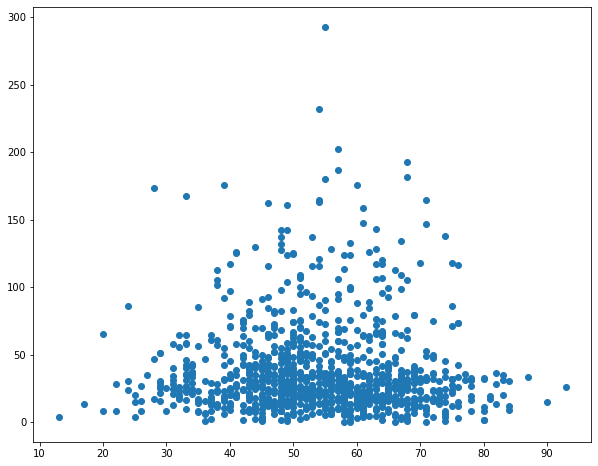

In [24]:
# Split the x and y value to be plotted
xValues = np.array(resultUnchanged['AGE_AT_DIAGNOSIS'])[:, None]
yValues = np.array(resultUnchanged['OS_MONTHS'])
plt.figure(figsize=(10, 8))
plt.scatter(xValues, yValues)

In [26]:
Males = resultUnchanged[resultUnchanged['SEX'] == 'Male']
Females = resultUnchanged[resultUnchanged['SEX'] == 'Female']

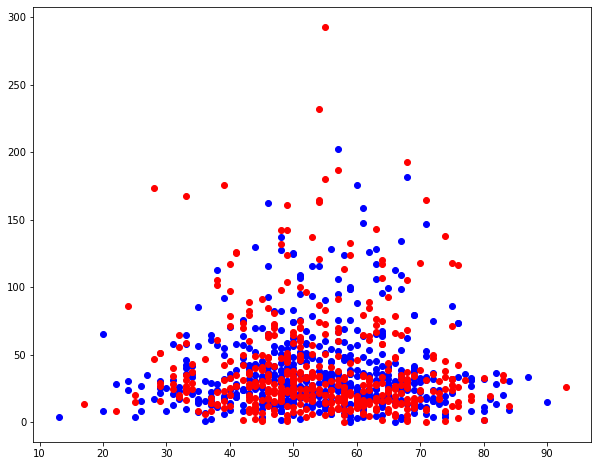

In [27]:
xValuesMales = np.array(Males['AGE_AT_DIAGNOSIS'])[:, None]
yValuesMales = np.array(Males['OS_MONTHS'])

xValuesFemales = np.array(Females['AGE_AT_DIAGNOSIS'])[:, None]
yValuesFemales = np.array(Females['OS_MONTHS'])


plt.figure(figsize=(10, 8))
plt.scatter(xValuesMales, yValuesMales, label = 'Male', color = 'blue')
plt.scatter(xValuesFemales, yValuesFemales, label = 'Female', color = 'red')

### Seaborn

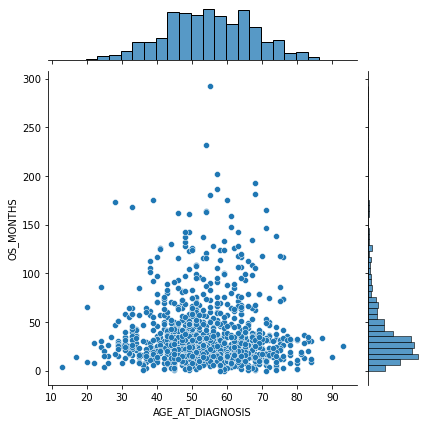

In [28]:
sns.jointplot(x='AGE_AT_DIAGNOSIS', y='OS_MONTHS', data=resultUnchanged)

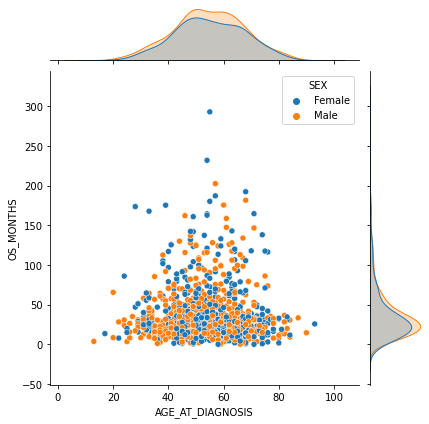

In [78]:
sns.jointplot(x='AGE_AT_DIAGNOSIS', y='OS_MONTHS', hue='SEX', data=resultUnchanged)

### Plotly

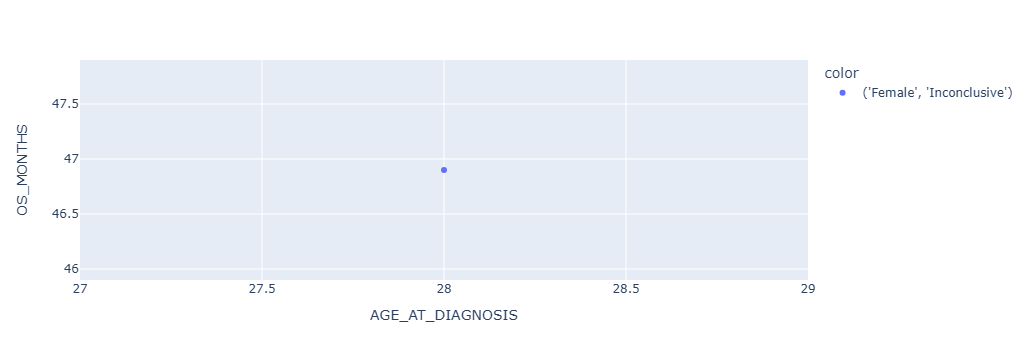

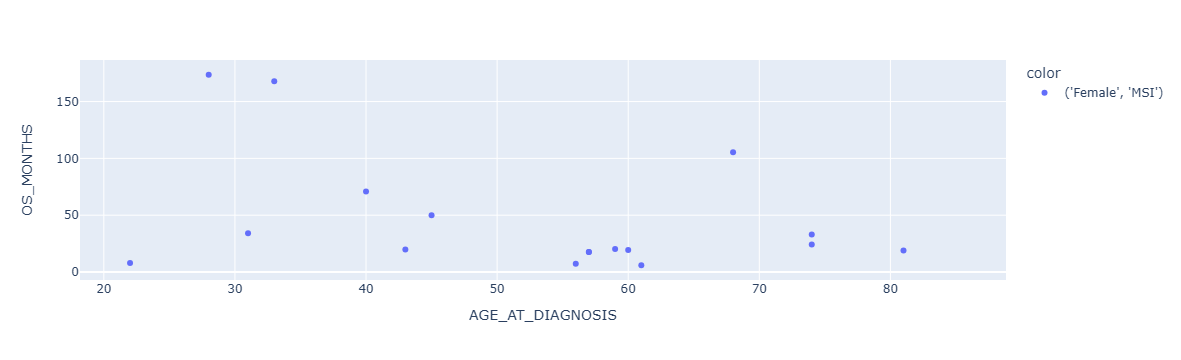

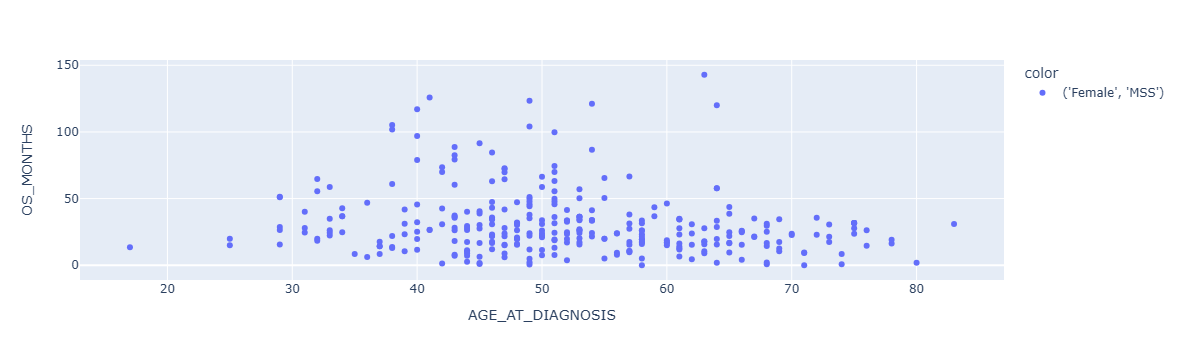

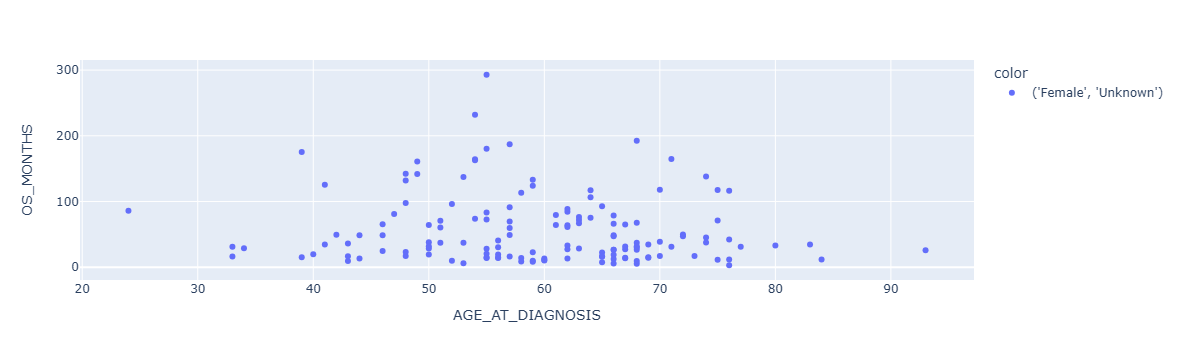

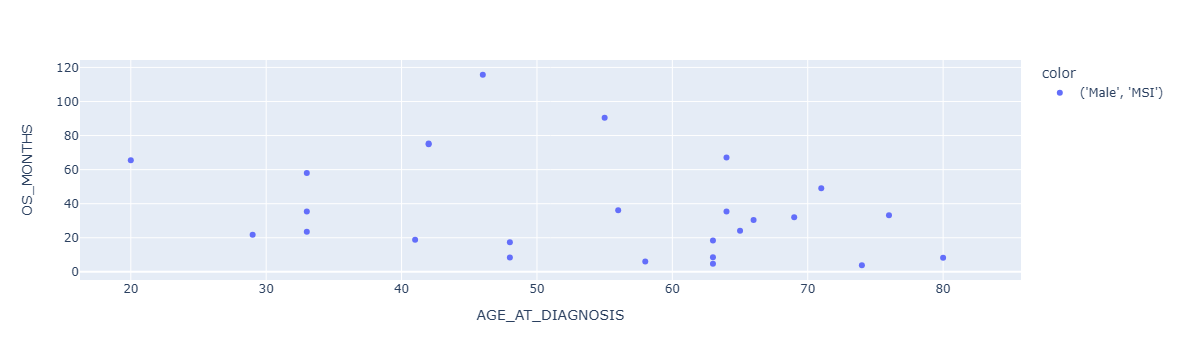

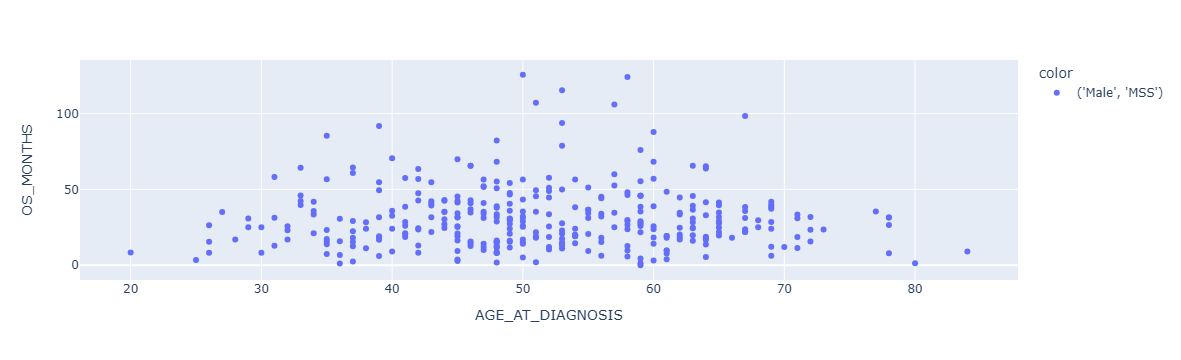

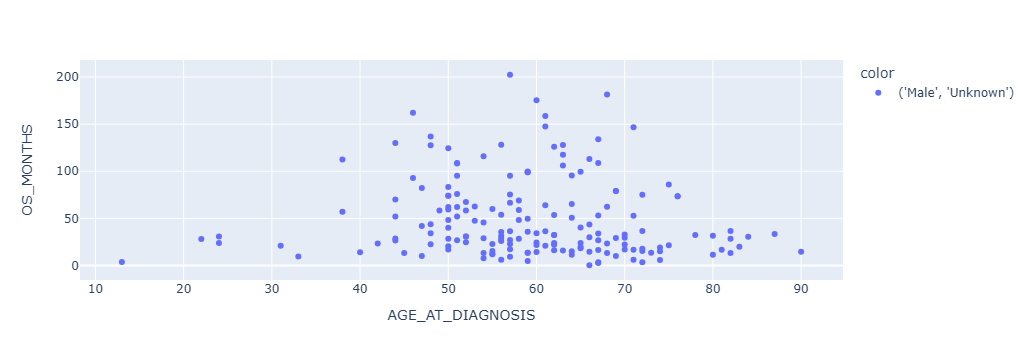

In [36]:
valuesToInsert = ['SEX', "MSI_STATUS"]
group_and_visualize_plots(valuesToInsert)

## KMeans Clustering Model + Visualization

In [39]:
# preparation of the data for training of the model
xPandas = resultUnchanged[['AGE_AT_DIAGNOSIS','OS_MONTHS']]
xPandas = xPandas.dropna()
X = xPandas.to_numpy()

print(resultUnchanged.shape)
print(X.shape)

(1134, 41)
(1013, 2)


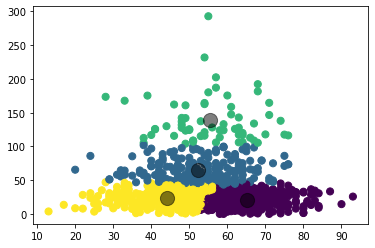

In [40]:
four_clusters = display_and_visualize_cluster(4, X)

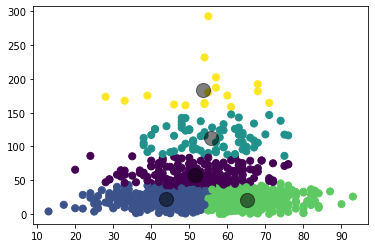

In [107]:
five_clusters = display_and_visualize_cluster(5, X)

In [103]:
elbow_sse = {}
for k in range(2, 30):
# What is strange is that if you make the range (1, 30)
# then this function will not run
    km = KMeans(n_clusters=k, random_state=1957) 
    km.fit(X)
    elbow_sse[k] = km.inertia_

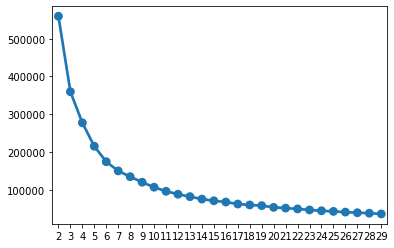

In [104]:
sns.pointplot(x=list(elbow_sse.keys()), y=list(elbow_sse.values()))
plt.show()

# Liver Metastasis Data Analysis Only

In [16]:
temporaryDF = obtainFullPatientInfo()

liverString = 'Liver'
#liverOnlyFirstSite = temporaryDF.loc[[temporaryDF['FIRST_SITE_OF_METS'].str.contains(liverString)] || [temporaryDF['METASTATIC_BIOPSY_SITE'].str.contains(liverString)]]
liverOnlyFirstSite = temporaryDF.loc[temporaryDF['FIRST_SITE_OF_METS'].str.contains(liverString)]
liverOnlyMBS = temporaryDF.loc[temporaryDF['METASTATIC_BIOPSY_SITE'].str.contains(liverString)]
liverOnly = pd.merge(liverOnlyFirstSite, liverOnlyMBS, how = 'inner')

In [17]:
# Run this line only to export files that contain only liver metastatis patients
liverOnly.to_csv(r'liverMetastasisOnly.csv', index=False)
liverOnly.to_excel(r'liverMetastasisOnly.xlsx', index=False)

### Correlation Between the Variables

<AxesSubplot:>

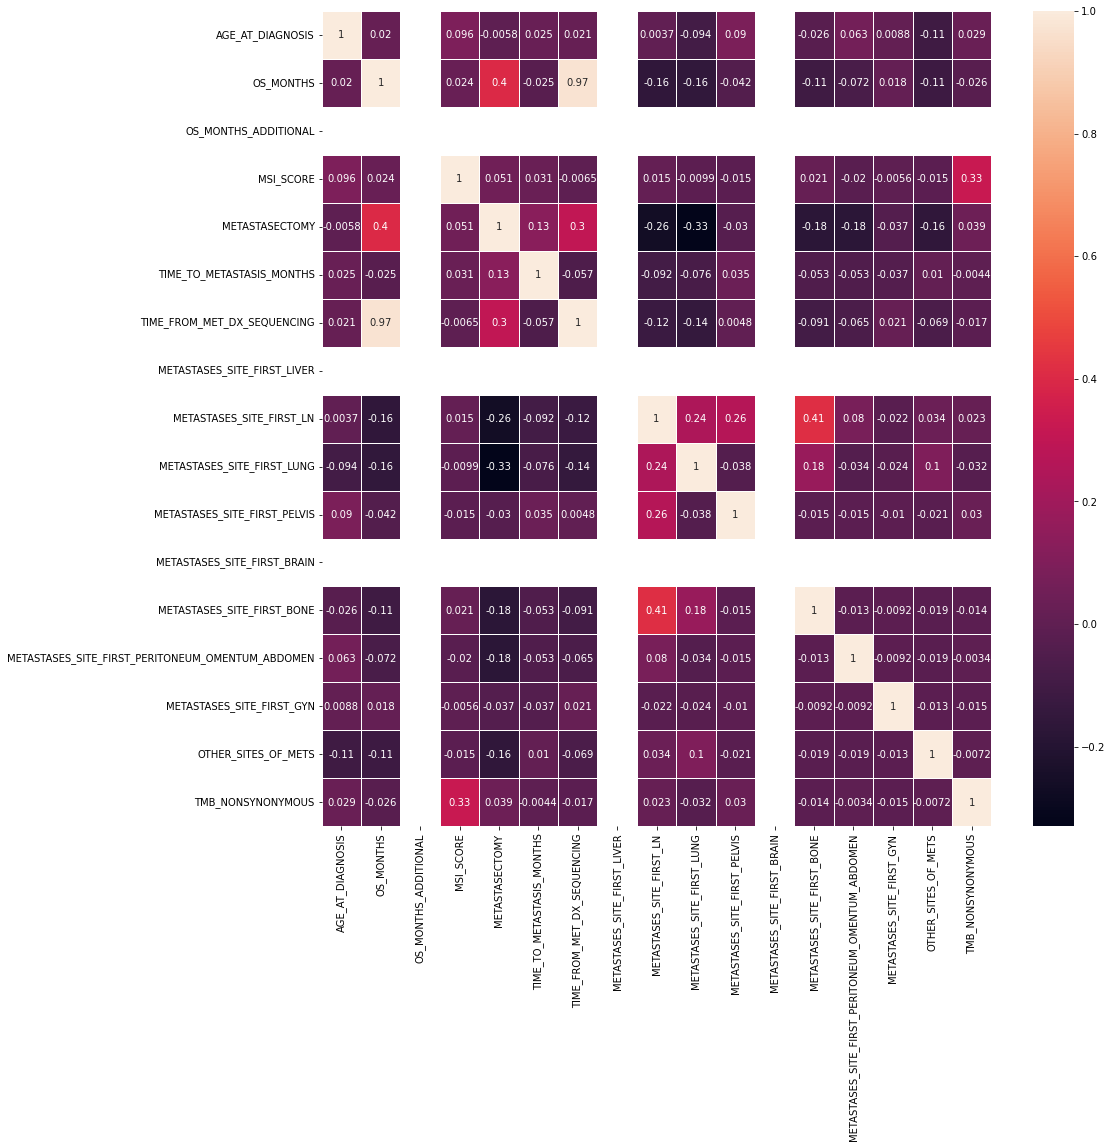

In [60]:
# Visual representation of the correlation between the variables
corr = liverOnly.corr()

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(corr, annot=True, linewidths=.5, ax=ax)

OS_MONTHS TIME_FROM_MET_DX_SEQUENCING
0.9721430447713816



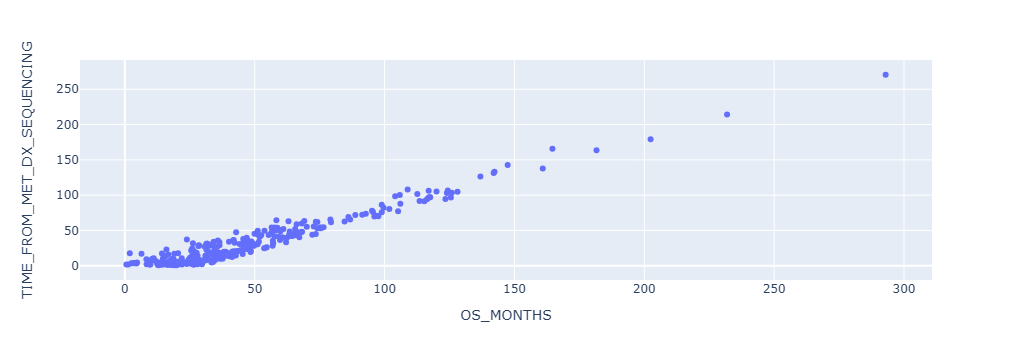

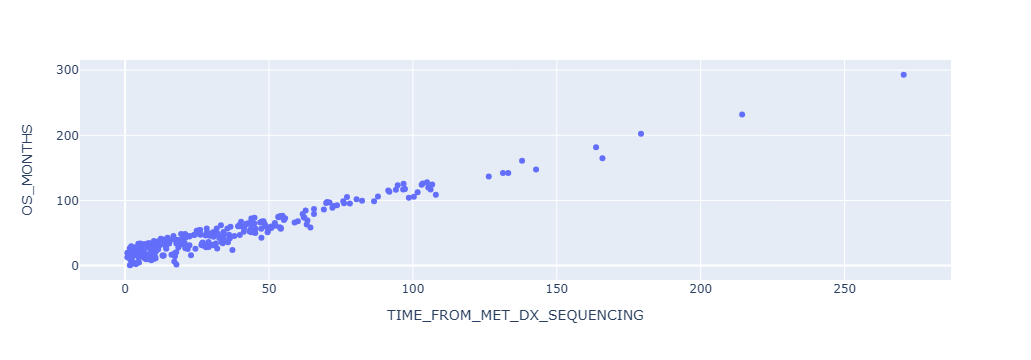

MSI_SCORE TMB_NONSYNONYMOUS
0.32534256068336437



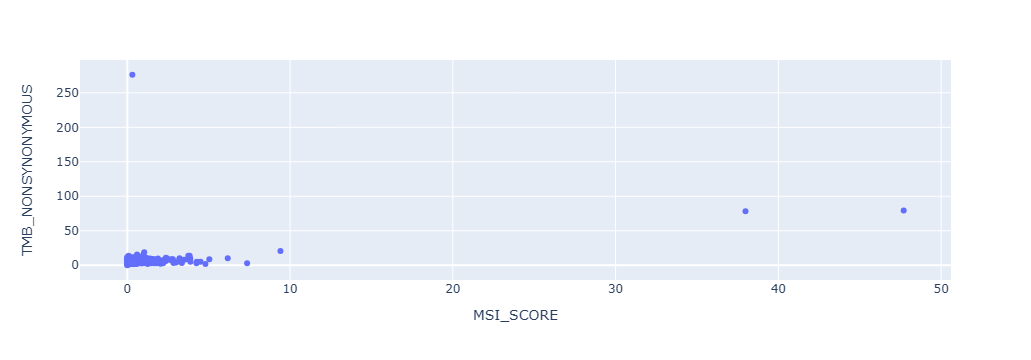

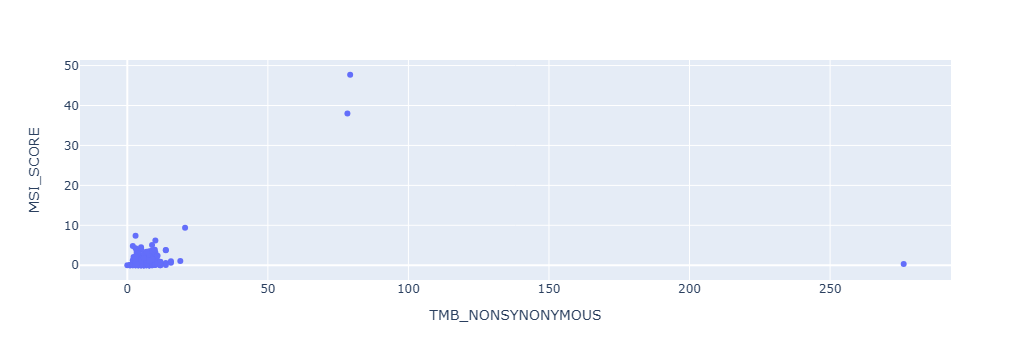

METASTASECTOMY OS_MONTHS
0.40193484976687144



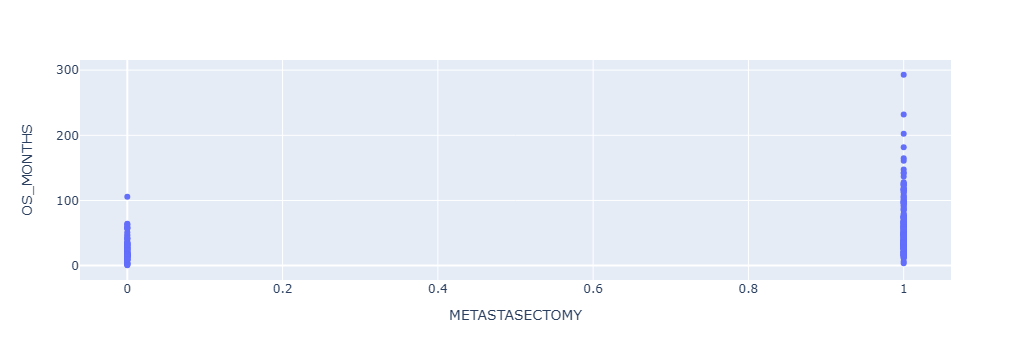

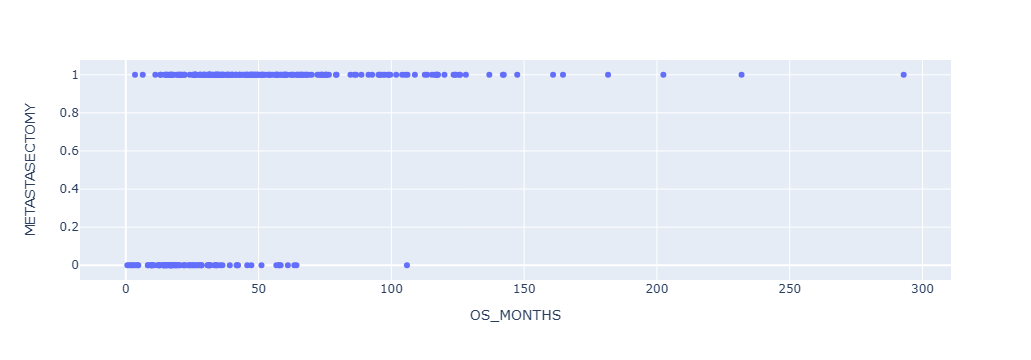

METASTASECTOMY TIME_FROM_MET_DX_SEQUENCING
0.30245181498646084



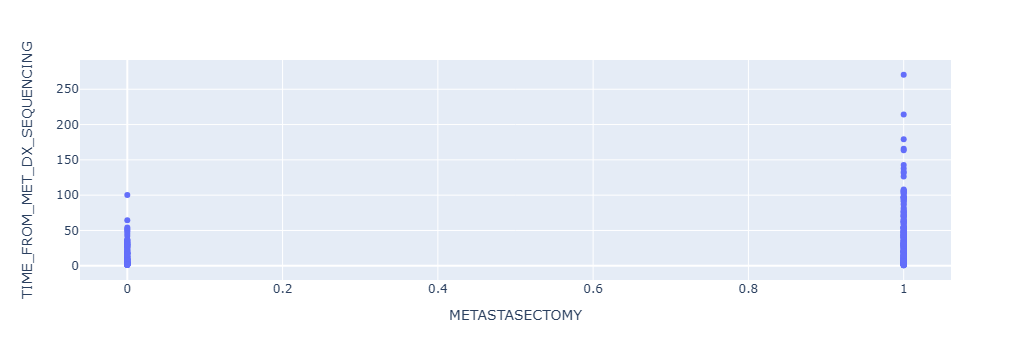

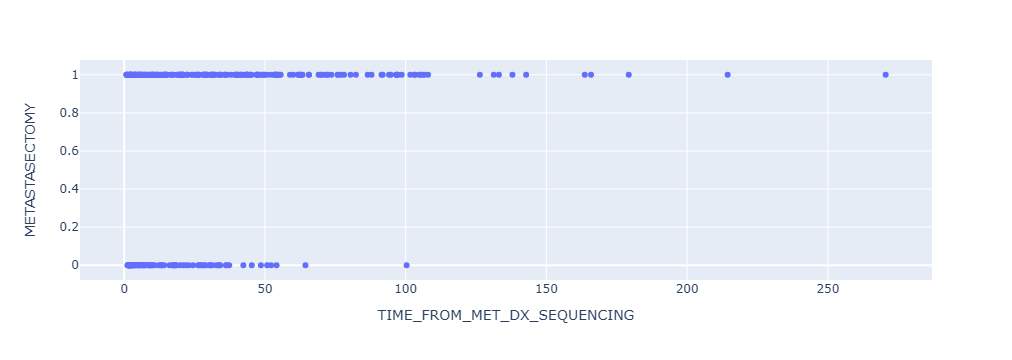

METASTASES_SITE_FIRST_LN METASTASES_SITE_FIRST_LUNG
0.24130941691402347



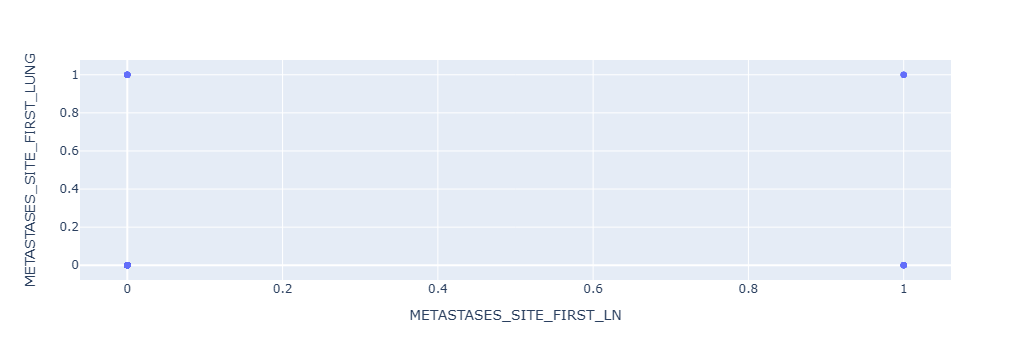

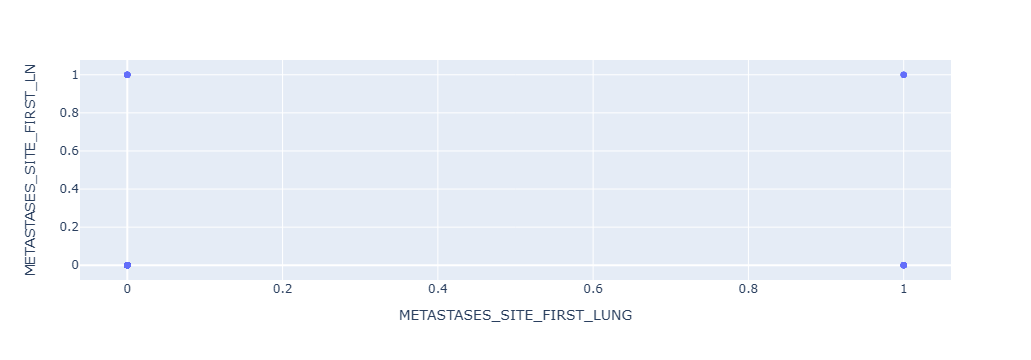

METASTASES_SITE_FIRST_LN METASTASES_SITE_FIRST_PELVIS
0.26387233370492247



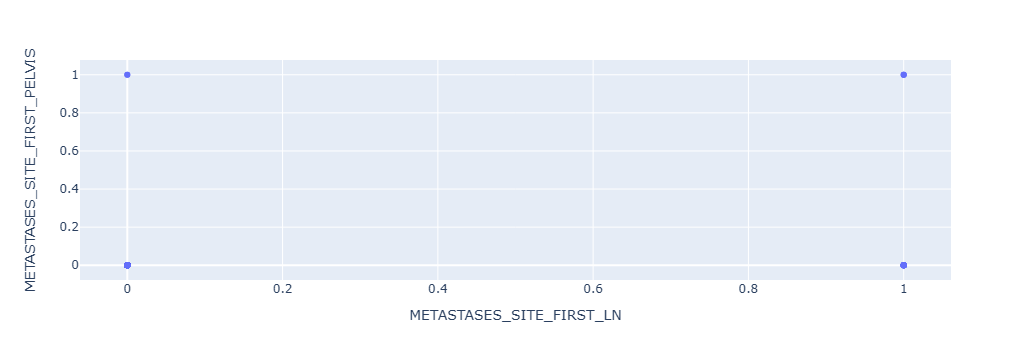

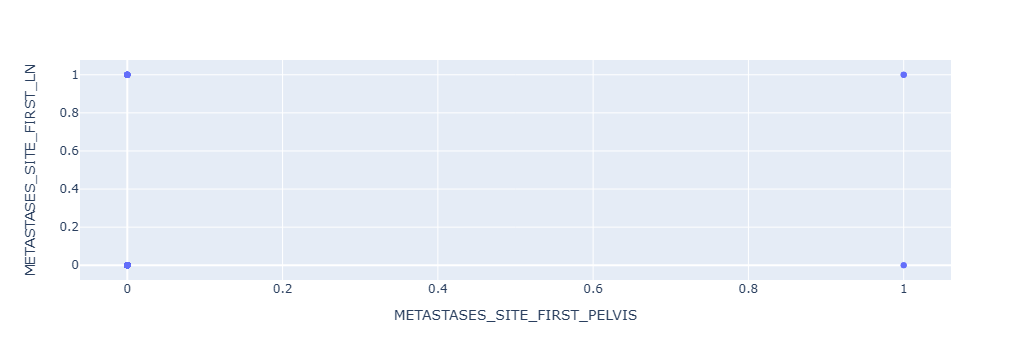

METASTASES_SITE_FIRST_BONE METASTASES_SITE_FIRST_LN
0.41371225797118616



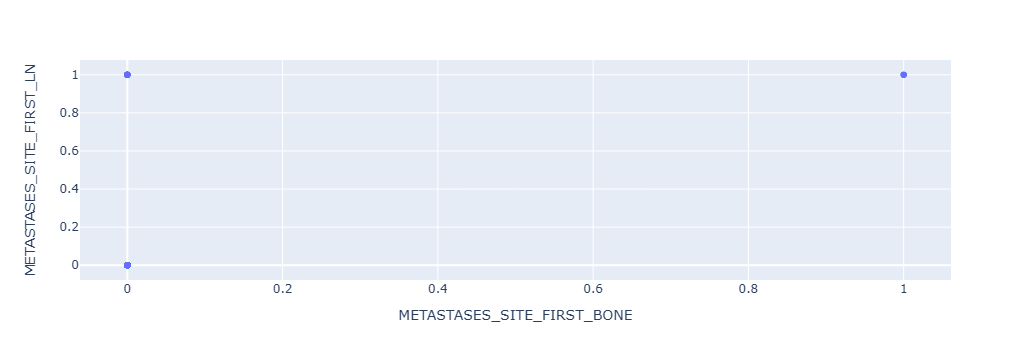

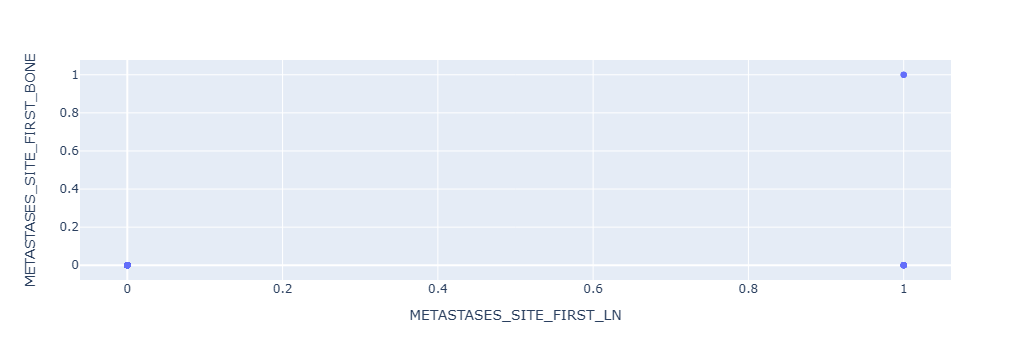

In [97]:
# The following block of code is used to iterate over the Pandas Dataframe containing the correlations between the variables

relevantColumns = set()

for rowIndex, row in corr.iterrows(): 
    #iterates over rows
    for columnIndex, value in row.items():
    # iterates over columns
        # the value of 0.2 was picked arbitrarily, if higher values of correlation are required, then the below line can be adjusted
        if (value > 0.2) and (rowIndex < columnIndex):
            # for values that show some degree of correlation, their values are printed and the graphs are 
            # visualized to graphically show the relationships between the two variables
            relevantColumns.add(rowIndex)
            relevantColumns.add(columnIndex)
            print(rowIndex, columnIndex)
            print(value)
            print()
            fig = px.scatter(liverOnly, x=rowIndex, y=columnIndex, hover_data=["PATIENT_ID", "SAMPLE_ID"])
            fig.show()
            fig = px.scatter(liverOnly, x=columnIndex, y=rowIndex, hover_data=["PATIENT_ID", "SAMPLE_ID"])
            fig.show()

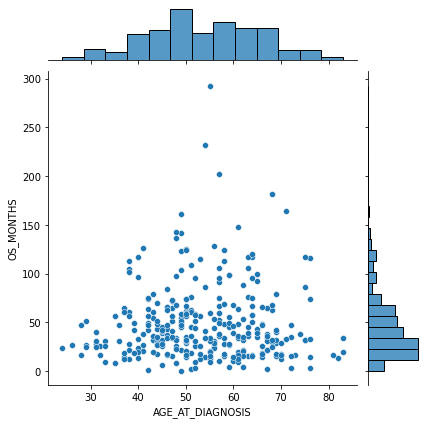

In [63]:
sns.jointplot(x='AGE_AT_DIAGNOSIS', y='OS_MONTHS', data=liverOnly)

In [83]:
listRelevantLiverColumns = []
for i in relevantColumns:
    listRelevantLiverColumns.append(i)

In [89]:
subsetLiver = liverOnly[liverOnly.columns[liverOnly.columns.isin(listRelevantLiverColumns)]]

In [90]:
subsetLiver

OS_MONTHS  MSI_SCORE  METASTASECTOMY  TIME_FROM_MET_DX_SEQUENCING  \
0        23.87        NaN               0                    37.300000   
1        16.00       0.37               0                    22.900000   
2        48.50       0.89               1                    20.866667   
3        54.17       0.27               1                    25.633333   
4        73.53       2.64               1                    44.966667   
..         ...        ...             ...                          ...   
306      17.30       1.22               1                     6.166667   
307      14.03       1.65               0                     1.433333   
308       9.83       0.00               0                     1.800000   
309      25.83       1.82               1                    14.300000   
310      55.37       0.19               1                    43.566667   

     METASTASES_SITE_FIRST_LN  METASTASES_SITE_FIRST_LUNG  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           1                           1   
..                        ...                         ...   
306                         0                           0   
307                         0                           0   
308                         0                           1   
309                         0                           0   
310                         0                           0   

     METASTASES_SITE_FIRST_PELVIS  METASTASES_SITE_FIRST_BONE  \
0                               0                           0   
1                               0                           0   
2                               0                           0   
3                               0                           0   
4                               0                           0   
..                            ...                         ...   
306                             0                           0   
307                             0                           0   
308                             0                           0   
309                             0                           0   
310                             0                           0   

     TMB_NONSYNONYMOUS  
0             4.436621  
1             6.654932  
2             8.873242  
3             6.654932  
4             7.764087  
..                 ...  
306           7.829758  
307           2.936159  
308          11.744636  
309           5.872318  
310           3.458792  

[311 rows x 9 columns]

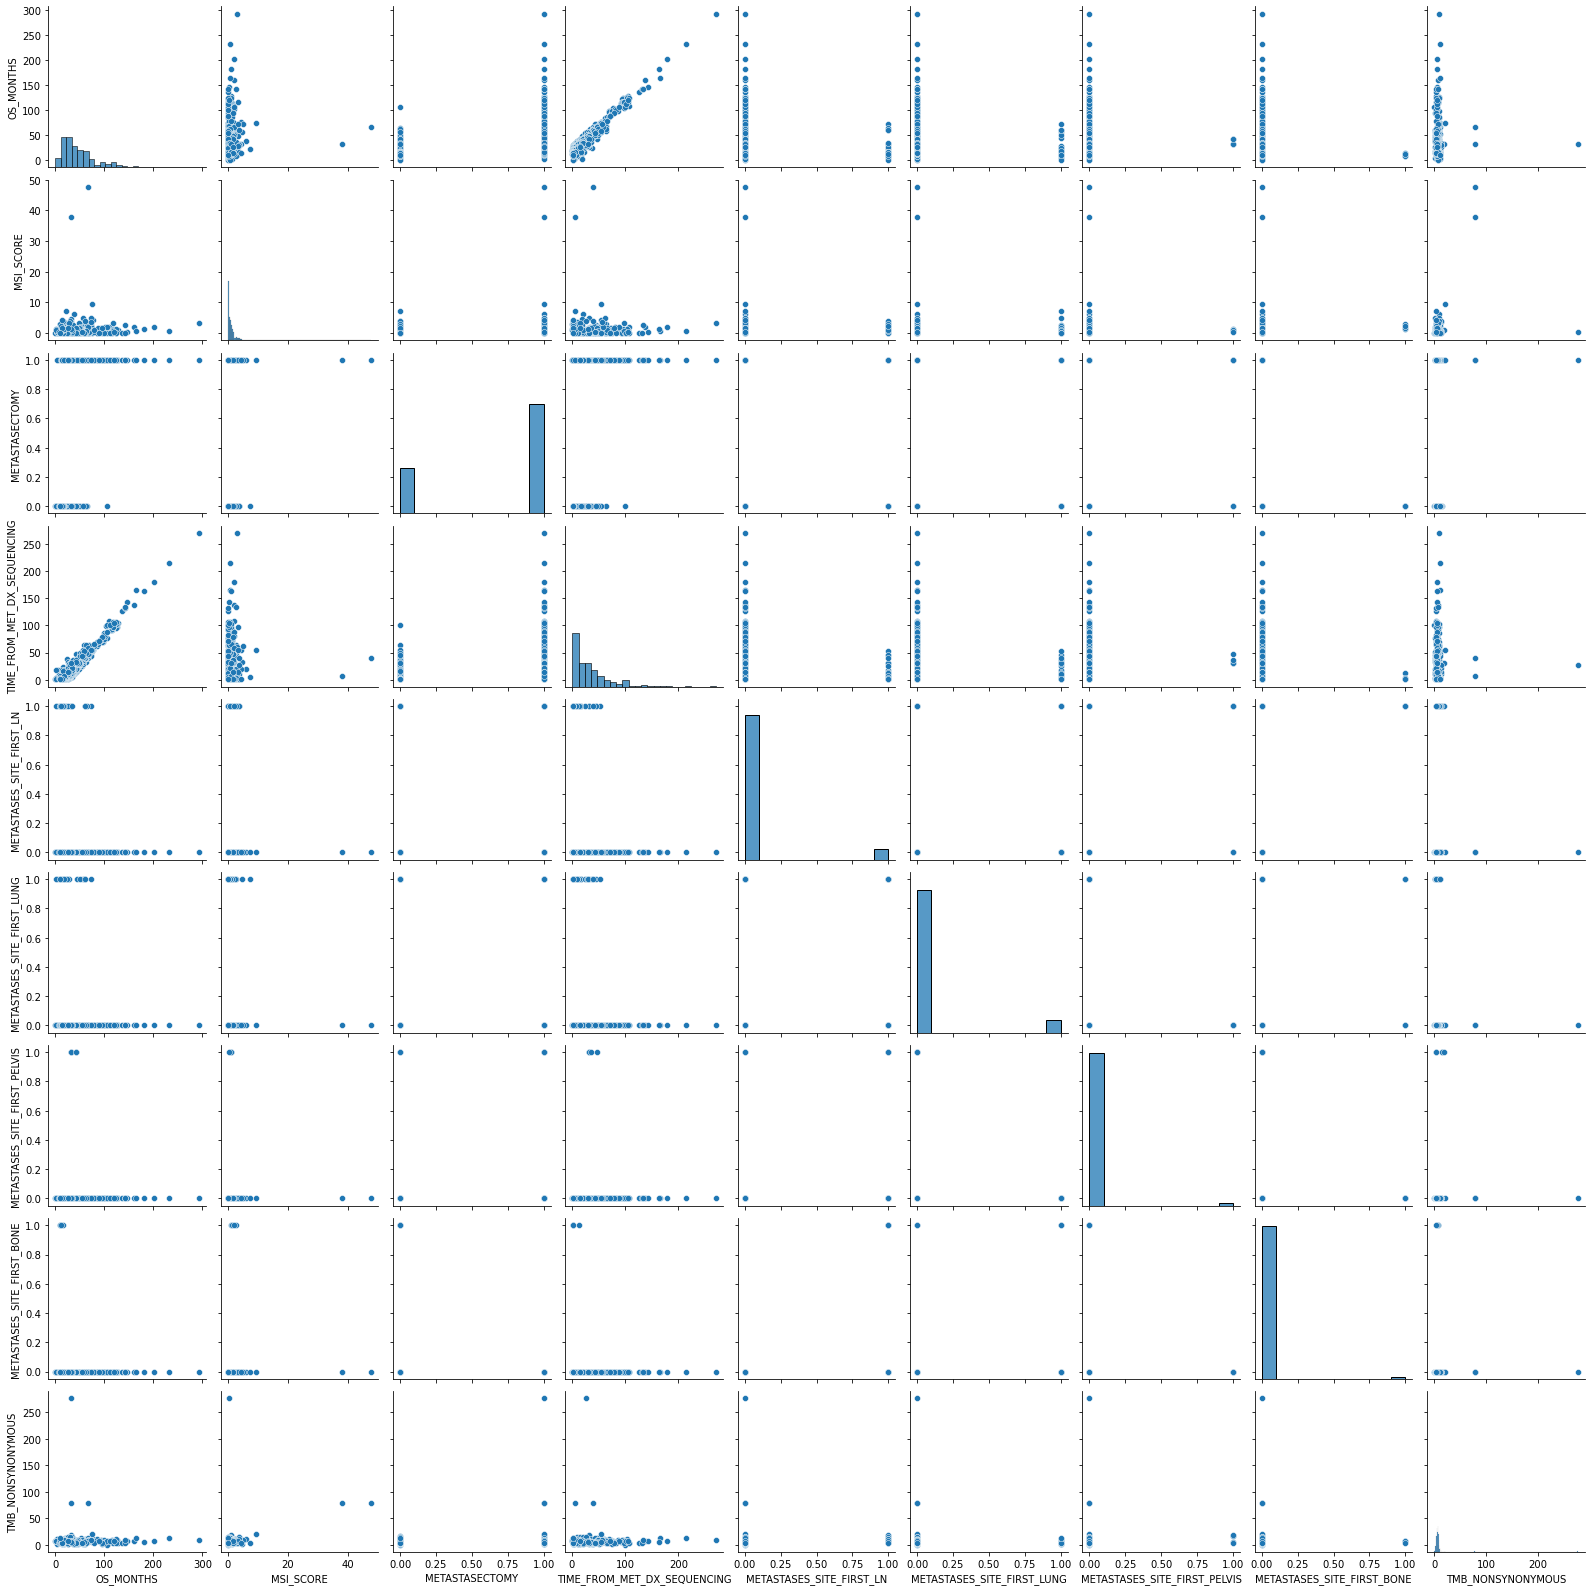

In [91]:
sns.pairplot(subsetLiver, height=2.5)

### Pre-Requisites for Running Random Forest and Neural Network Sections

In [21]:
# Full patients data containing both tables, with filled in empty columns
temporaryDF = obtainFullPatientInfo()

# Identifies the relevant string that we are searching for
liverString = 'Liver'

# Identifies patients with Liver that are in one of the desired groups, which are then (inner) merged 
liverOnlyFirstSite = temporaryDF.loc[temporaryDF['FIRST_SITE_OF_METS'].str.contains(liverString)]
liverOnlyMBS = temporaryDF.loc[temporaryDF['METASTATIC_BIOPSY_SITE'].str.contains(liverString)]
liverOnly = pd.merge(liverOnlyFirstSite, liverOnlyMBS, how = 'inner')

In [22]:
liverOnly.shape

(311, 41)

In [23]:
# The reason Version 2 comes before Version 1 is that Version 2 was developed second; version run does not need to be outside
# of its section because it is only used in that section
xPandasLiverVersion2 = liverOnly.drop(['VITAL_STATUS', 'OS_MONTHS_ADDITIONAL', 'PATIENT_ID', 'OS_STATUS', 'SAMPLE_ID'], axis=1)
yPandasLiverVersion2 = liverOnly['VITAL_STATUS']

In [24]:
xPandasLiverVersion2 = prepareContainerForAnalysis(xPandasLiverVersion2)

In [25]:
currentMap2 = {}
uniqueYValues = np.sort(yPandasLiverVersion2.unique())
for i in range(len(uniqueYValues)):
    currentMap2[uniqueYValues[i]] = i
yPandasLiverVersion2 = yPandasLiverVersion2.map(currentMap2)

In [26]:
print(currentMap2)

{'Deceased': 0, 'Living': 1}


In [27]:
mapping = list(currentMap2)
print(mapping)

['Deceased', 'Living']


In [28]:
yPandasLiverVersion2.to_csv(r'yPandasLiverVersion2.csv', index=False)

In [29]:
# Split the data into training and test sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(xPandasLiverVersion2, yPandasLiverVersion2, test_size=0.2)

In [30]:
#X_train2.shape
y_train2.shape

(248,)

## Random Forest Models

### Random Forest with OS_Months as Dependent Variable

In [18]:
xPandasLiver = liverOnly.drop(['OS_MONTHS', 'OS_MONTHS_ADDITIONAL', 
                               'PATIENT_ID', 'OS_STATUS', 'SAMPLE_ID'], axis=1)
yPandasLiver = liverOnly['OS_MONTHS']

In [19]:
xPandasLiver = prepareContainerForAnalysis(xPandasLiver)

In [20]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(xPandasLiver, yPandasLiver, test_size=0.2)

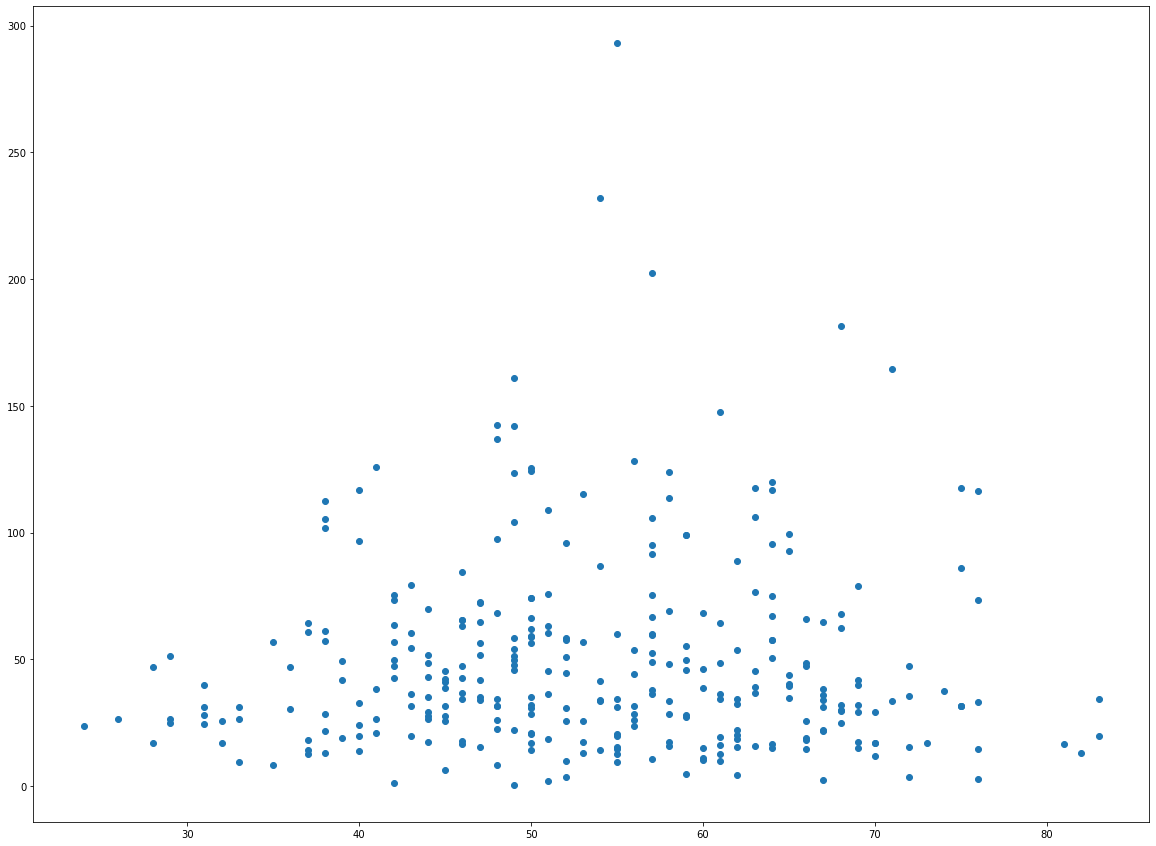

In [21]:
xValues = np.array(liverOnly['AGE_AT_DIAGNOSIS'])
yValues = np.array(liverOnly['OS_MONTHS'])
plt.figure(figsize=(20, 15))
plt.scatter(xValues, yValues)

In [22]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

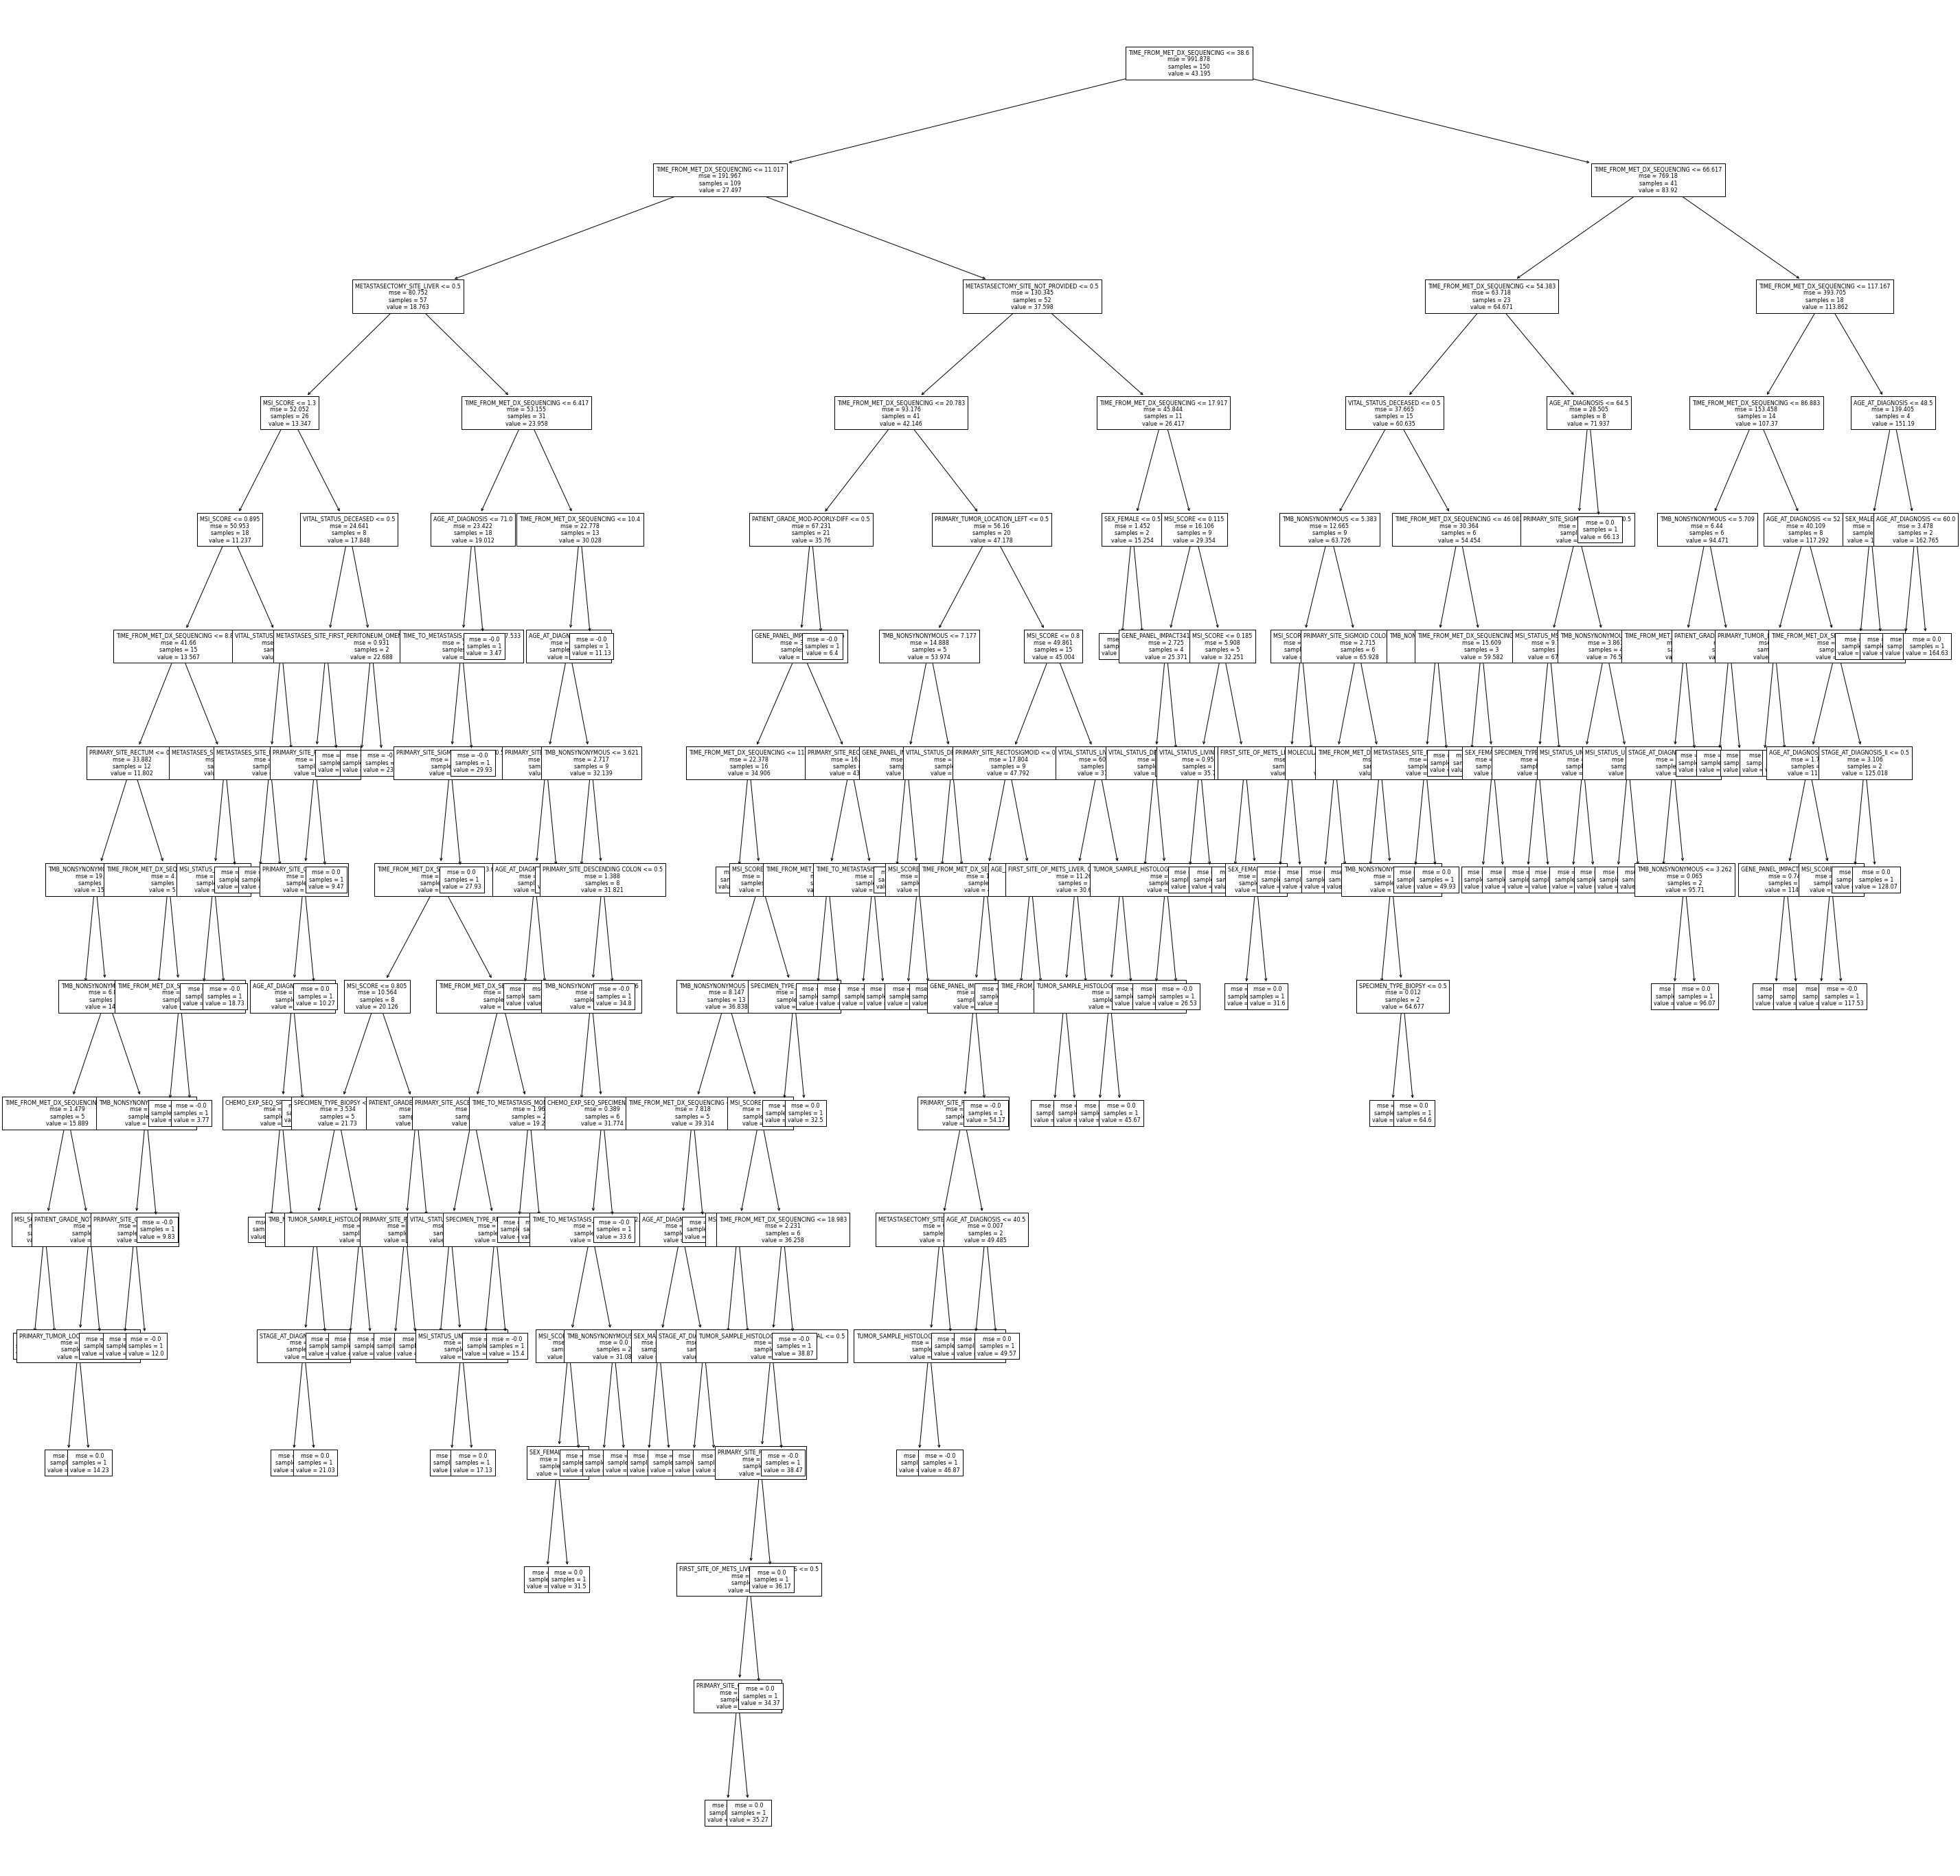

In [42]:
from sklearn import tree
plt.figure(figsize=(50,50))  # set plot size (denoted in inches)
tree.plot_tree(rfr.estimators_[0], feature_names=X_train.columns, fontsize=8)
plt.show()

### Random Forest with Vital Status as Dependent Variable

In [31]:
clf = RandomForestClassifier()
clf.fit(X_train2, y_train2)
y_pred2 = clf.predict(X_test2)

In [32]:
X_train2_updated = X_train2.copy()
X_test2_updated = X_test2.copy()

In [34]:
for i in range(len(clf.feature_importances_)):
    print(X_train2.columns[i], clf.feature_importances_[i])

AGE_AT_DIAGNOSIS 0.07395602098095413
OS_MONTHS 0.08118981250510707
MSI_SCORE 0.07081076553215353
METASTASECTOMY 0.04507339474292907
TIME_TO_METASTASIS_MONTHS 0.0224785811699389
TIME_FROM_MET_DX_SEQUENCING 0.08971789260073253
METASTASES_SITE_FIRST_LIVER 0.0
METASTASES_SITE_FIRST_LN 0.0053840075587799794
METASTASES_SITE_FIRST_LUNG 0.005120538512771531
METASTASES_SITE_FIRST_PELVIS 0.012267639384135363
METASTASES_SITE_FIRST_BRAIN 0.0
METASTASES_SITE_FIRST_BONE 0.0012017950405205065
METASTASES_SITE_FIRST_PERITONEUM_OMENTUM_ABDOMEN 0.0030418960880927385
METASTASES_SITE_FIRST_GYN 0.0
OTHER_SITES_OF_METS 0.006658505168959372
TMB_NONSYNONYMOUS 0.07558076386874786
SEX_FEMALE 0.019121963668576093
SEX_MALE 0.0197620638815913
PATIENT_GRADE_MOD-POORLY-DIFF 0.00372986534137304
PATIENT_GRADE_MOD_DIFF 0.01148689097077118
PATIENT_GRADE_NOT_PROVIDED 0.01220418744045451
PATIENT_GRADE_POORLY-DIFF 0.002790276157829095
CHEMO_EXP_SEQ_SPECIMEN_NO 0.013592335771085063
CHEMO_EXP_SEQ_SPECIMEN_YES 0.01247613412402

In [31]:
listOfValuesToDelete = []

for i in range(len(X_train2.columns)):
    if clf.feature_importances_[i] == 0:
        listOfValuesToDelete.append(X_train2.columns[i])
            
for index in listOfValuesToDelete:
    del X_train2_updated[index]
    del X_test2_updated[index]

In [34]:
percentAccuracy = calculatePercentAccuracyModel(y_pred2, y_test2)

print(percentAccuracy)

0.7142857142857143


In [25]:
averageAccuracyCLF = averageSuccessRateCLF(25, X_train2, y_train2, X_test2, y_test2)
print(averageAccuracyCLF)

0.7123809523809524


In [34]:
clf2 = RandomForestClassifier(max_depth = 3)
clf2.fit(X_train2_updated, y_train2)
y_pred_2_new = clf2.predict(X_test2_updated)

In [35]:
percentAccuracy2 = calculatePercentAccuracyModel(y_pred_2_new, y_test2)

In [36]:
print(percentAccuracy2)

0.7619047619047619


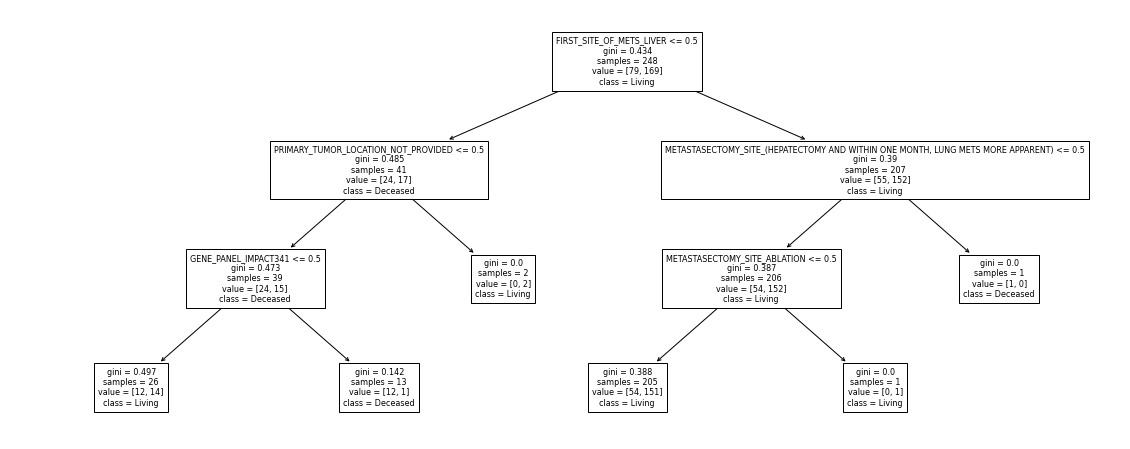

In [37]:
from sklearn import tree
import graphviz

fig = plt.figure(figsize=(20,8))  # set plot size (denoted in inches)
_ = tree.plot_tree(clf.estimators_[0], feature_names=X_train2.columns, class_names=mapping, fontsize=8)
plt.show()
fig.savefig("decistion_tree.png")

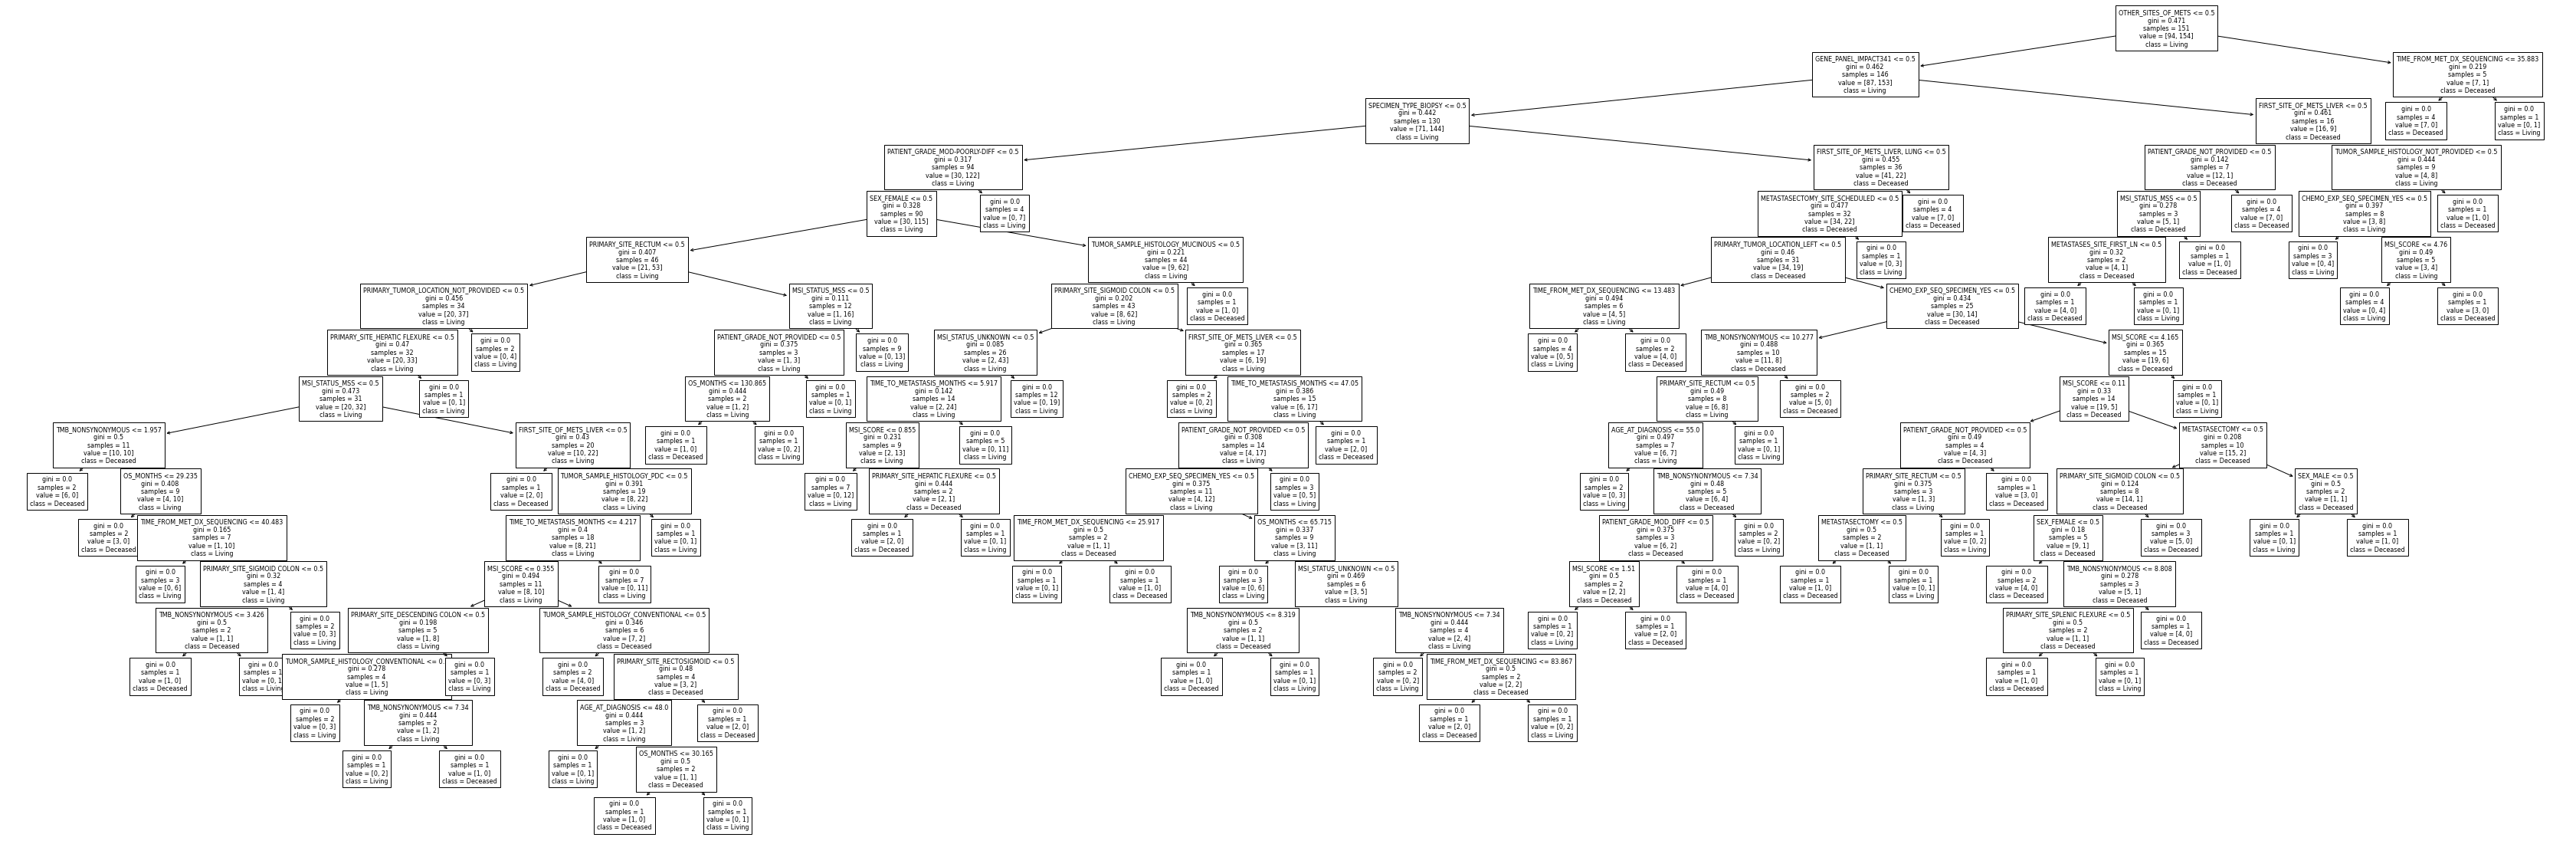

In [314]:
from sklearn import tree
import graphviz

fig = plt.figure(figsize=(60,20))  # set plot size (denoted in inches)
_ = tree.plot_tree(clf.estimators_[0], feature_names=X_train2.columns, class_names=mapping, fontsize=8)
plt.show()
fig.savefig("decistion_tree.png")

In [315]:
rfr2 = RandomForestRegressor()
rfr2.fit(X_train2, y_train2)

y_pred2 = rfr2.predict(X_test2)

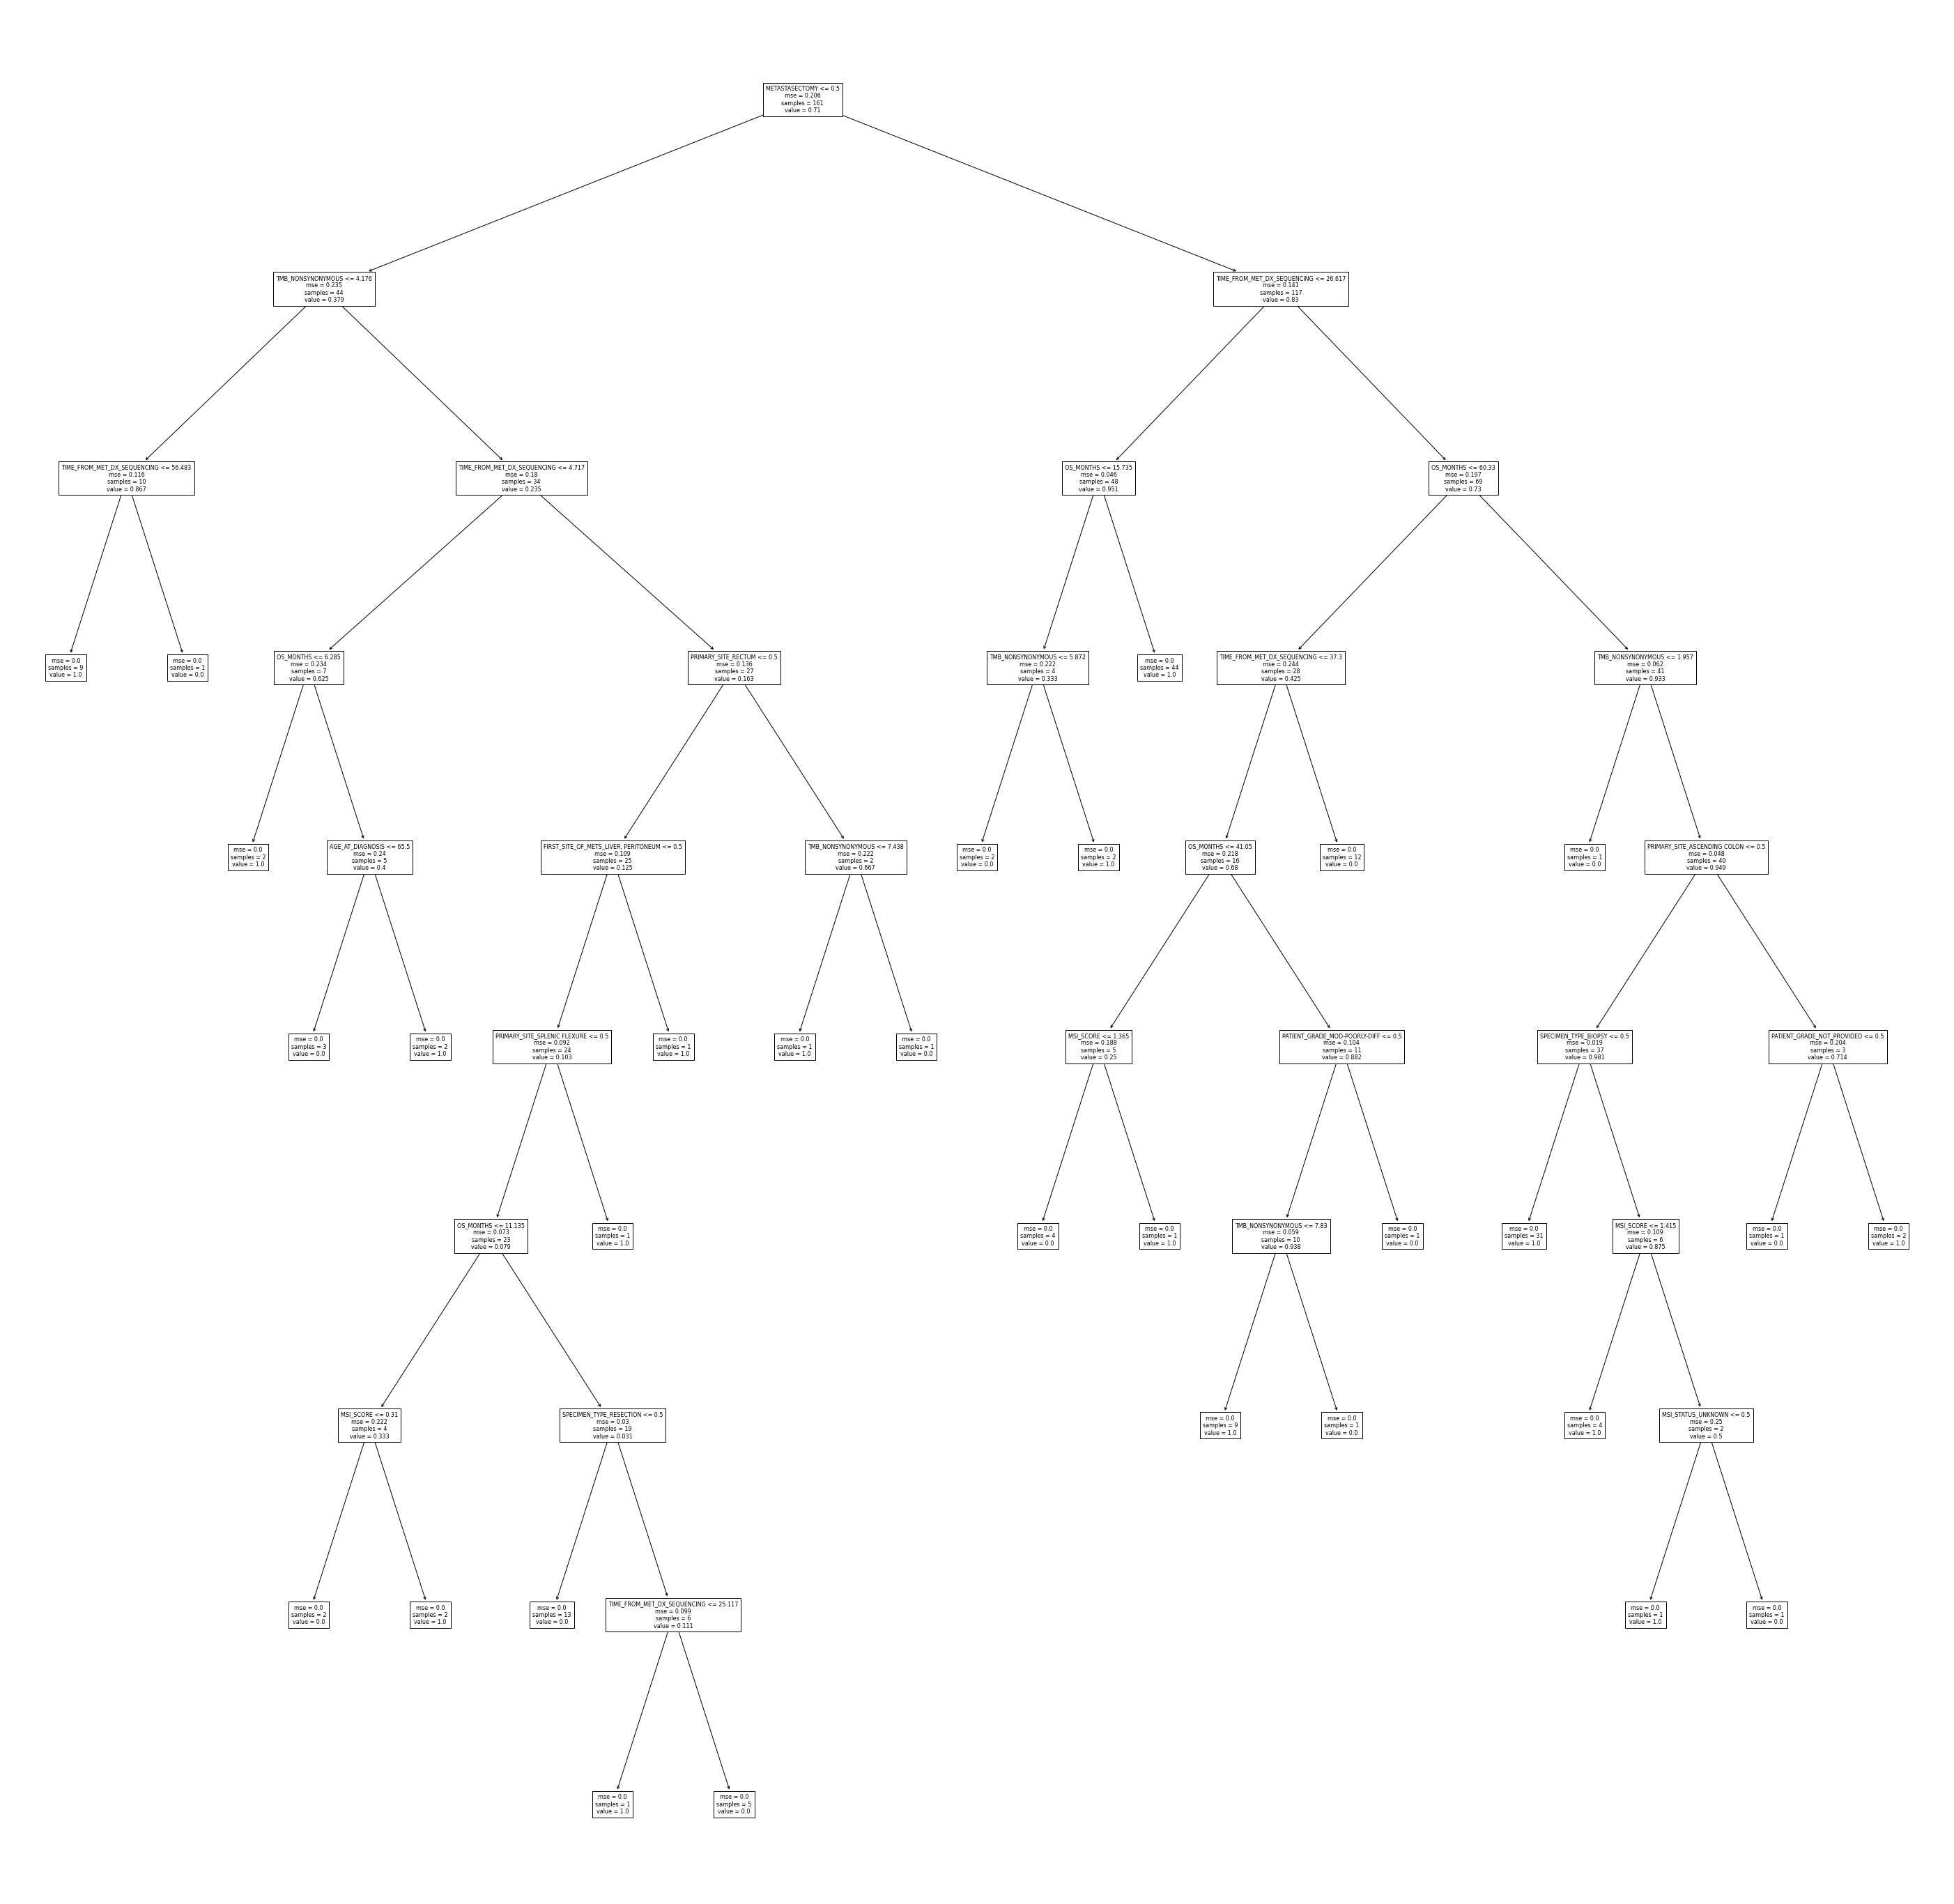

In [97]:
from sklearn import tree
plt.figure(figsize=(50,50))  # set plot size (denoted in inches)
tree.plot_tree(rfr2.estimators_[0], feature_names=X_train2.columns, fontsize=8)
plt.show()

## Neural Networks Models

### Keras Neural Networks

In [27]:
# Literature states that the number of hidden layers 
# should be between 1 and the number of (inputs + outputs)/2
# so we find the upper limit here
numColumns = len(X_train2.columns)
numNodesLayer1 = math.ceil(numColumns/2)

#### Single (Hidden) Layer Neural Network - Few Nodes (Method 1: No Declaration of Sequential Model)

In [28]:
testInputs = Input(shape=X_train2.shape[1])
testX = Dense(4, activation="relu")(testInputs)

# A rectified linear unit (ReLU) is an activation function that introduces the property of non-linearity to a deep learning model and solves the vanishing gradients issue

#x = Dense(4, activation="")(x)
testX = Dense(1, activation="sigmoid")(testX)
testModel = Model(testInputs, testX)

In [29]:
testModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
print("[INFO] training model...")
testModel.fit(X_train2, y_train2, epochs=150, batch_size=10)

_, accuracy = testModel.evaluate(X_train2, y_train2)
print('Accuracy: %.2f' % (accuracy*100))

# make predictions on the testing data
print("[INFO] predicting vital status of patients...")
testPredictions = testModel.predict(X_test2)

[INFO] training model...
Epoch 1/150
25/25 [==============================] - 1s 2ms/step - loss: 3.0854 - accuracy: 0.3306
Epoch 2/150
25/25 [==============================] - 0s 1ms/step - loss: 1.8352 - accuracy: 0.3306
Epoch 3/150
25/25 [==============================] - 0s 2ms/step - loss: 1.2663 - accuracy: 0.3306
Epoch 4/150
25/25 [==============================] - 0s 1ms/step - loss: 0.9971 - accuracy: 0.3427
Epoch 5/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8677 - accuracy: 0.3589
Epoch 6/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7944 - accuracy: 0.4355
Epoch 7/150
25/25 [==============================] - 0s 1ms/step - loss: 0.7538 - accuracy: 0.5081
Epoch 8/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7264 - accuracy: 0.5524
Epoch 9/150
25/25 [==============================] - 0s 1ms/step - loss: 0.7073 - accuracy: 0.6129
Epoch 10/150
25/25 [==============================] - 0s 1ms/step - loss: 0.6943 - a

In [30]:
testOpt = Adam(learning_rate=0.0001, weight_decay=0.0001/ 200)
testModel.compile(loss="mean_absolute_percentage_error", optimizer=testOpt)
# train the model
print("[INFO] training model...")
testModel.fit(x=X_train2, y=y_train2)
# make predictions on the testing data
print("[INFO] predicting vital status of patients...")
testPredictions = testModel.predict(X_test2)

[INFO] training model...
8/8 [==============================] - 0s 2ms/step - loss: 131638560.0000
[INFO] predicting vital status of patients...
2/2 [==============================] - 0s 3ms/step


In [40]:
predictionsArrayNeuralNetwork = roundArray(testPredictions)

In [45]:
print(calculatePercentAccuracyModel(predictionsArrayNeuralNetwork,y_test2))

0.6825396825396826


#### Single (Hidden) Layer Neural Network (Method 1: No Declaration of Sequential Model)

In [46]:
inputs = Input(shape=X_train2.shape[1])
x = Dense(numNodesLayer1, activation="relu")(inputs)
x = Dense(1, activation="sigmoid")(x)
modelOne = Model(inputs, x)

In [47]:
modelOne.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
print("[INFO] training model...")
modelOne.fit(X_train2, y_train2, epochs=150, batch_size=10)

_, accuracy = modelOne.evaluate(X_train2, y_train2)
print('Accuracy: %.2f' % (accuracy*100))

# make predictions on the testing data
print("[INFO] predicting vital status of patients...")
predictionsOne = modelOne.predict(X_test2)

[INFO] training model...
Epoch 1/150
25/25 [==============================] - 1s 2ms/step - loss: 5.1307 - accuracy: 0.4395
Epoch 2/150
25/25 [==============================] - 0s 2ms/step - loss: 2.3511 - accuracy: 0.5927
Epoch 3/150
25/25 [==============================] - 0s 2ms/step - loss: 1.0972 - accuracy: 0.5000
Epoch 4/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7708 - accuracy: 0.5565
Epoch 5/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6576 - accuracy: 0.6411
Epoch 6/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5636 - accuracy: 0.7258
Epoch 7/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5347 - accuracy: 0.7298
Epoch 8/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5003 - accuracy: 0.7661
Epoch 9/150
25/25 [==============================] - 0s 1ms/step - loss: 0.4528 - accuracy: 0.7863
Epoch 10/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4352 - a

In [48]:
opt = Adam(learning_rate=0.0001, weight_decay=0.0001/ 200)
modelOne.compile(loss="mean_absolute_percentage_error", optimizer=opt)
# train the model
print("[INFO] training model...")
modelOne.fit(x=X_train2, y=y_train2)
# make predictions on the testing data
print("[INFO] predicting vital status of patients...")
predictionsOne = modelOne.predict(X_test2)

[INFO] training model...
8/8 [==============================] - 0s 2ms/step - loss: 23754820.0000
[INFO] predicting vital status of patients...
2/2 [==============================] - 0s 3ms/step


In [49]:
predictionsArrayNeuralNetwork = roundArray(predictionsOne)

In [50]:
print(calculatePercentAccuracyModel(predictionsArrayNeuralNetwork,y_test2))

0.6984126984126984


#### Multiple (Hidden) Layer Neural Network (Method 1: No Declaration of Sequential Model)

In [67]:
nodeLayers = []
placeHolder = numNodesLayer1
while placeHolder > 1:
    nodeLayers.append(placeHolder)
    placeHolder = math.floor(placeHolder / 2)

In [68]:
nodeLayers

[51, 25, 12, 6, 3]

In [69]:
inputsOne = Input(shape=X_train2.shape[1])
xOne = Dense(numNodesLayer1, activation="relu")(inputsOne)
for i in nodeLayers:
    if i == nodeLayers[0]:
        continue
    xOne = Dense(i, activation="relu")(xOne)
#x = Dense(4, activation="")(x)
xOne = Dense(1, activation="sigmoid")(xOne)
modelTwo = Model(inputsOne, xOne)

In [70]:
modelTwo.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
print("[INFO] training model...")
modelTwo.fit(X_train2, y_train2, epochs=150, batch_size=10)

_, accuracy = modelTwo.evaluate(X_train2, y_train2)
print('Accuracy: %.2f' % (accuracy*100))

# make predictions on the testing data
print("[INFO] predicting vital status of patients...")
predictionsTwo = modelTwo.predict(X_test2)

[INFO] training model...
Epoch 1/150
25/25 [==============================] - 1s 2ms/step - loss: 0.6742 - accuracy: 0.6331
Epoch 2/150
25/25 [==============================] - 0s 1ms/step - loss: 0.6136 - accuracy: 0.6774
Epoch 3/150
25/25 [==============================] - 0s 1ms/step - loss: 0.6019 - accuracy: 0.6774
Epoch 4/150
25/25 [==============================] - 0s 1ms/step - loss: 0.5933 - accuracy: 0.6774
Epoch 5/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5849 - accuracy: 0.6774
Epoch 6/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5693 - accuracy: 0.6774
Epoch 7/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5548 - accuracy: 0.6774
Epoch 8/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5300 - accuracy: 0.7016
Epoch 9/150
25/25 [==============================] - 0s 1ms/step - loss: 0.4840 - accuracy: 0.7500
Epoch 10/150
25/25 [==============================] - 0s 1ms/step - loss: 0.4507 - a

In [ ]:
predictionsArrayNeuralNetwork = roundArray(predictionsTwo)

In [ ]:
print(calculatePercentAccuracyModel(predictionsArrayNeuralNetwork))

#### Triple (Hidden) Layer Neural Network (Method 2: No Declaration of Sequential Model)

In [72]:
model = Sequential()
model.add(Dense(12, input_shape=(101,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [73]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train2, y_train2, epochs=150, batch_size=10)

_, accuracy = model.evaluate(X_train2, y_train2)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/150
25/25 [==============================] - 1s 2ms/step - loss: 5.2270 - accuracy: 0.3266
Epoch 2/150
25/25 [==============================] - 0s 1ms/step - loss: 1.2733 - accuracy: 0.4355
Epoch 3/150
25/25 [==============================] - 0s 2ms/step - loss: 0.9190 - accuracy: 0.5282
Epoch 4/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8216 - accuracy: 0.5242
Epoch 5/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7908 - accuracy: 0.5161
Epoch 6/150
25/25 [==============================] - 0s 1ms/step - loss: 0.7373 - accuracy: 0.6169
Epoch 7/150
25/25 [==============================] - 0s 2ms/step - loss: 0.7015 - accuracy: 0.6008
Epoch 8/150
25/25 [==============================] - 0s 1ms/step - loss: 0.6659 - accuracy: 0.6371
Epoch 9/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6462 - accuracy: 0.6492
Epoch 10/150
25/25 [==============================] - 0s 1ms/step - loss: 0.6259 - accuracy: 0.6613
Epoch 11/

In [74]:
predictionsThree = model.predict(X_test2)

2/2 [==============================] - 0s 2ms/step


In [ ]:
predictionsArrayNeuralNetwork = roundArray(predictionsThree)

In [ ]:
print(calculatePercentAccuracyModel(predictionsArrayNeuralNetwork))

#### Testing Different (Number of) Layers

In [47]:
print("Accuracy current model is: ", averageSuccessRateModel(25,[2,1], X_train2, y_train2, X_test2, y_test2))
print("Accuracy current model is: ", averageSuccessRateModel(25,[4,1], X_train2, y_train2, X_test2, y_test2))
print("Accuracy current model is: ", averageSuccessRateModel(25,[8,1], X_train2, y_train2, X_test2, y_test2))
print("Accuracy current model is: ", averageSuccessRateModel(25,[16,1], X_train2, y_train2, X_test2, y_test2))
print("Accuracy current model is: ", averageSuccessRateModel(25,[32,1], X_train2, y_train2, X_test2, y_test2))
print("Accuracy current model is: ", averageSuccessRateModel(25,[64,1], X_train2, y_train2, X_test2, y_test2))
print("Accuracy current model is: ", averageSuccessRateModel(25,[128,1], X_train2, y_train2, X_test2, y_test2))

[INFO] training model...
8/8 [==============================] - 0s 2ms/step - loss: 0.1093 - accuracy: 0.8911
Accuracy: 89.11
[INFO] predicting vital status of patients...
2/2 [==============================] - 0s 2ms/step
[INFO] training model...
8/8 [==============================] - 0s 1ms/step - loss: 0.1371 - accuracy: 0.8387
Accuracy: 83.87
[INFO] predicting vital status of patients...
2/2 [==============================] - 0s 2ms/step
[INFO] training model...
8/8 [==============================] - 0s 1ms/step - loss: 0.1167 - accuracy: 0.8508
Accuracy: 85.08
[INFO] predicting vital status of patients...
2/2 [==============================] - 0s 2ms/step
[INFO] training model...
8/8 [==============================] - 0s 2ms/step - loss: 0.1104 - accuracy: 0.8548
Accuracy: 85.48
[INFO] predicting vital status of patients...
2/2 [==============================] - 0s 2ms/step
[INFO] training model...
8/8 [==============================] - 0s 2ms/step - loss: 0.1088 - accuracy: 0.846

In [46]:
print("Accuracy current model is: ", averageSuccessRateModel(25, [4,1], X_train2, y_train2, X_test2, y_test2))
print("Accuracy current model is: ", averageSuccessRateModel(25, [8,1], X_train2, y_train2, X_test2, y_test2))
print("Accuracy current model is: ", averageSuccessRateModel(25, [12,1], X_train2, y_train2, X_test2, y_test2))
print("Accuracy current model is: ", averageSuccessRateModel(25, [16,1], X_train2, y_train2, X_test2, y_test2))
print("Accuracy current model is: ", averageSuccessRateModel(25, [20,1], X_train2, y_train2, X_test2, y_test2))
print("Accuracy current model is: ", averageSuccessRateModel(25, [40,1], X_train2, y_train2, X_test2, y_test2))
print("Accuracy current model is: ", averageSuccessRateModel(25, [80,1], X_train2, y_train2, X_test2, y_test2))
print("Accuracy current model is: ", averageSuccessRateModel(25, [120,1], X_train2, y_train2, X_test2, y_test2))

print("Accuracy current model is: ", averageSuccessRateModel(25,[3,3,1], X_train2, y_train2, X_test2, y_test2))
print("Accuracy current model is: ", averageSuccessRateModel(25,[3,5,1], X_train2, y_train2, X_test2, y_test2))
print("Accuracy current model is: ", averageSuccessRateModel(25,[3,7,1], X_train2, y_train2, X_test2, y_test2))
print("Accuracy current model is: ", averageSuccessRateModel(25,[3,9,1], X_train2, y_train2, X_test2, y_test2))
print("Accuracy current model is: ", averageSuccessRateModel(25,[3,11,1], X_train2, y_train2, X_test2, y_test2))

[INFO] training model...
8/8 [==============================] - 0s 2ms/step - loss: 0.0892 - accuracy: 0.8952
Accuracy: 89.52
[INFO] predicting vital status of patients...
2/2 [==============================] - 0s 1ms/step
[INFO] training model...
8/8 [==============================] - 0s 2ms/step - loss: 0.0975 - accuracy: 0.8589
Accuracy: 85.89
[INFO] predicting vital status of patients...
2/2 [==============================] - 0s 2ms/step
[INFO] training model...
8/8 [==============================] - 0s 2ms/step - loss: 0.3185 - accuracy: 0.6815
Accuracy: 68.15
[INFO] predicting vital status of patients...
2/2 [==============================] - 0s 3ms/step
[INFO] training model...
8/8 [==============================] - 0s 2ms/step - loss: 0.0956 - accuracy: 0.8871
Accuracy: 88.71
[INFO] predicting vital status of patients...
2/2 [==============================] - 0s 2ms/step
[INFO] training model...
8/8 [==============================] - 0s 2ms/step - loss: 0.2171 - accuracy: 0.681

# Drug Impact on Patients

## Pre-processing of Data

In [54]:
patientsWithDrugInfo = pd.read_excel("../Publication PDFs/NIHMS928716-supplement-2.xlsx", header = 2)

In [55]:
for i in patientsWithDrugInfo.columns:
    print(i, len(patientsWithDrugInfo[i].unique()))
    print(patientsWithDrugInfo[i].unique())

Sample ID 1134
['P-0000119-T01-IM3' 'P-0000241-T01-IM3' 'P-0000493-T01-IM3' ...
 'P-0014296-T01-IM6' 'P-0014404-T01-IM6' 'P-0014415-T01-IM6']
Patient ID 1099
['P-0000119' 'P-0000241' 'P-0000493' ... 'P-0014296' 'P-0014404'
 'P-0014415']
Cancer Type 1
['Colorectal']
Sample Type 2
['Metastasis' 'Primary']
Primary Tumor Site 13
['Cecum' 'Ascending Colon' 'Sigmoid Colon' 'Transverse Colon'
 'Rectosigmoid' 'Rectum' 'Descending Colon' 'Splenic Flexure'
 'Hepatic Flexure' 'Colon' nan 'Left Colon' 'Proximal Colon']
Metastatic Tumor Biopsy Site 35
['Ovary' 'Peritoneum' 'Liver' 'Chest Wall' nan 'Abdomen' 'Lymph Node'
 'Skin' 'Lung' 'Omentum' 'Brain' 'Pelvis' 'Soft Tissue' 'Vagina'
 'Sigmoid Colon' 'Peritoneal Fluid' 'Pleura' 'Small Bowel'
 'Paracolic Gutter' 'Lymph node' 'Mesentery' 'RetroPeritoneum'
 'Abdominal Wall' 'Bladder' 'Adrenal Gland' 'Peritoneal Implant'
 'Peritoneal implant on Sigmoid Colon' 'Rectum' 'Spine' 'Diaphragm'
 'Paraspinal Mass' 'Kidney' 'Cerebellum' 'Sacral Mass' 'Skull bas

In [56]:
# If columns exist that only have 1 single unique value, then they can be eliminated from the search, 
# as they do not contribute to the model's performance in any way and only make the input larger than it needs to be
for i in patientsWithDrugInfo.columns:
    numUniqueVals = len(patientsWithDrugInfo[i].unique())
    if numUniqueVals < 2:
        del patientsWithDrugInfo[i]

In [57]:
# In certain column, there exist cells that contain semi-colon separated values
# Thus, instead of listing these values as a distinct value to one-hot encode, as is the default, via the library's function
# it is necessary to split these values into singular values first

# For example, if a cell has a value 'A;B', and A and B already exist as separate one-hot encoded columns, then instead of creating
# a column 'A;B' with a value of 1, then this is split into columns 'A' and 'B', both with a value of 1 in each column

columnsNecessaryForManualEncoding = ['Level R1', 'Level 2B', 'Level 3B']
patientsWithDrugInfo = containerToEncode(patientsWithDrugInfo, columnsNecessaryForManualEncoding)

In [58]:
patientsWithDrugInfo

Sample ID Patient ID Sample Type Primary Tumor Site  \
0     P-0000119-T01-IM3  P-0000119  Metastasis              Cecum   
1     P-0000241-T01-IM3  P-0000241  Metastasis    Ascending Colon   
2     P-0000493-T01-IM3  P-0000493  Metastasis      Sigmoid Colon   
3     P-0000511-T01-IM3  P-0000511  Metastasis      Sigmoid Colon   
4     P-0000520-T01-IM3  P-0000520     Primary              Cecum   
...                 ...        ...         ...                ...   
1129  P-0014252-T01-IM6  P-0014252  Metastasis              Cecum   
1130  P-0014258-T01-IM6  P-0014258     Primary      Sigmoid Colon   
1131  P-0014296-T01-IM6  P-0014296  Metastasis      Sigmoid Colon   
1132  P-0014404-T01-IM6  P-0014404     Primary       Rectosigmoid   
1133  P-0014415-T01-IM6  P-0014415     Primary       Rectosigmoid   

     Metastatic Tumor Biopsy Site Primary Tumor Location MSK IMPACT Panel  \
0                           Ovary                  Right        IMPACT341   
1                      Peritoneum                  Right        IMPACT341   
2                           Liver                   Left        IMPACT341   
3                      Chest Wall                   Left        IMPACT341   
4                             NaN                  Right        IMPACT341   
...                           ...                    ...              ...   
1129                        Liver                  Right        IMPACT468   
1130                          NaN                   Left        IMPACT468   
1131                   Skull base                   Left        IMPACT468   
1132                          NaN                   Left        IMPACT468   
1133                          NaN                   Left        IMPACT468   

      Age at Diagnosis Stage at Diagnosis  Gender  ...  \
0                   67                 IV  Female  ...   
1                   49                 IV  Female  ...   
2                   24                 IV    Male  ...   
3                   39                 IV  Female  ...   
4                   64                 II    Male  ...   
...                ...                ...     ...  ...   
1129                59                III    Male  ...   
1130                69                 IV    Male  ...   
1131                46                 IV  Female  ...   
1132                62                III  Female  ...   
1133                49                 IV    Male  ...   

     Level 3B: alpelisib(PIK3CA p.H1047L)  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
...                                   ...   
1129                                    0   
1130                                    0   
1131                                    0   
1132                                    0   
1133                                    0   

     Level 3B: Sonidegib,Vismodegib(PTCH1 p.Y1021*)  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   
...                                             ...   
1129                                              0   
1130                                              0   
1131                                              0   
1132                                              0   
1133                                              0   

      Level 3B: alpelisib(PIK3CA p.E726K) Level 3B: alpelisib(PIK3CA p.G106V)  \
0                                       0                                   0   
1                                       0                                   0   
2                                       0                                   0   
3                                    

In [59]:
# To examine the results of the manual one-hot encoding on the given columns, one may export the DF to a csv or excel file
patientsWithDrugInfo.to_csv(r'patientsWithDrugInfo.csv', index=False)
patientsWithDrugInfo.to_excel(r'patientsWithDrugInfo.xlsx', index=False)

In [60]:
# In this step we identify patients who have a liver MS or liver metastasectomy, in separate DFs and find the union of these DFs
liverPrimaryMS = patientsWithDrugInfo[patientsWithDrugInfo['Liver: First Site of Metastasis'] == 1]
patientsWithDrugInfo[['Metastasectomy Site']] = patientsWithDrugInfo[['Metastasectomy Site']].fillna('Not Provided')
liverMetastasectomy = patientsWithDrugInfo.loc[patientsWithDrugInfo['Metastasectomy Site'].str.contains('liver')]
# if the line below was replaced with:
    # df_union = pd.concat([liverOnlyMSPatientswDrugInfo, liverOnlyMetasectPatientswDrugInfo])
# then duplicates would be preserved, hence, it is necessary to drop the duplicates to only consider unique patients(' samples)
liverDrugInfo = pd.concat([liverPrimaryMS,liverMetastasectomy]).drop_duplicates().reset_index(drop=True)

In [61]:
# From the line below, we can see that groups are closely related, but there are still a few patients from the liverMetastasectomy
# that would have been excluded had we not performed a union operation with the liverPrimaryMS group
print(liverPrimaryMS.shape)
print(liverMetastasectomy.shape)
print(liverDrugInfo.shape)

(729, 230)
(381, 230)
(735, 230)


In [62]:
# From this line we can see that there exist infinity values within certain cells of our dataset. The signifance of this is that 
# infinity values result in the model to only return NaN values in its result, making it useless; this detail is pertinent
# to consider, as it can lead to a lot of problems, as it had done for me during model development (for at least 3 hours)
liverDrugInfo['Ratio of Indel to Substitutions'].unique()

array([0.28571429, 0.33333333, 0.        , 0.125     , 0.25      ,
       0.42857143, 0.2       , 0.16666667, 0.11111111, 0.15384615,
       0.8       , 0.14285714, 0.5       , 0.4       , 0.375     ,
       0.07692308, 0.07142857, 0.13333333, 0.00403226, 0.046875  ,
       0.18181818, 0.26666667, 0.57142857, 1.        , 0.22222222,
       0.06521739, 0.75      , 0.66666667, 0.39215686, 0.26984127,
       0.1       , 2.        , 0.44642857, 0.54166667, 0.09090909,
       0.6       , 1.5       ,        inf, 0.71428571, 4.        ,
       0.04545454, 0.06666667, 0.08333333, 0.46296296, 0.36111111,
       0.58536585, 0.44444444, 1.2       , 0.0041841 , 0.48717949,
       0.47222222, 0.05555556])

In [63]:
# To deal with inf values, they are first replaced with NaN values, 
# which are accounted for in data pre-processing
liverDrugInfo.replace([np.inf, -np.inf], np.nan, inplace=True)

In [64]:
# Rankings/stages are orginal data, so they do not need to be one-hot encoded; thus, 
# they were mapped to their corresponding number
rankingMapped = {"I" : 1, "II" : 2, "III" : 3, "IV" : 4}
liverDrugInfo['Stage at Diagnosis'] = liverDrugInfo['Stage at Diagnosis'].map(rankingMapped)

In [65]:
# Now, the x (all inputs) and y values are prepared. 
    # First categorical values which are different to patients or duplicate info are removed
    # Second, Vital Status is turned into a binary representation to only have 1 output in the end
liverDrugInfoX = liverDrugInfo.drop(['Sample ID', 'Patient ID', 'VitaL Status', 'First Site(s) of Metastasis', 'Metastasectomy Site', 'Survival Date of dx to date of death or last FU for early stage primary (months)'], axis=1)
vitalStatusMapping = {"Deceased" : 0, "Living" : 1}
liverDrugInfo['VitaL Status'] = liverDrugInfo['VitaL Status'].map(vitalStatusMapping)
liverDrugInfoY = liverDrugInfo['VitaL Status']

In [66]:
# Once the x and y values are appropriate, then the x is further transformed so all remaining categorical is one-hot encoded
liverDrugInfoX = prepareContainerForAnalysis(liverDrugInfoX)

In [67]:
liverDrugInfoX

Age at Diagnosis  Stage at Diagnosis  MSIsensor Score  Metastasectomy  \
0                  67                   4             0.72               0   
1                  49                   4             0.27               0   
2                  24                   4             0.00               0   
3                  24                   4             0.89               1   
4                  63                   4             0.37               0   
..                ...                 ...              ...             ...   
730                33                   3             0.08               1   
731                78                   4             0.07               1   
732                34                   4             0.38               1   
733                68                   2             1.86               1   
734                63                   4             0.08               1   

     Survival Date of mets to date of death or last FU for mCRC (months)  \
0                                                27.37                     
1                                                24.00                     
2                                                23.87                     
3                                                85.97                     
4                                                16.00                     
..                                                 ...                     
730                                              34.93                     
731                                              32.43                     
732                                               0.00                     
733                                             192.30                     
734                                              24.37                     

     Time to metastasis (months)  Time from Met Dx to Sequencing  \
0                       0.000000                       38.933333   
1                       0.000000                       32.200000   
2                       0.000000                       37.300000   
3                       0.000000                       97.166667   
4                       0.000000                       22.900000   
..                           ...                             ...   
730                    25.533333                        6.166667   
731                     0.000000                       19.600000   
732                     0.000000                       12.000000   
733                    14.700000                      193.333333   
734                     0.000000                       24.166667   

     Liver: First Site of Metastasis  Lymph Nodes: First Site of Metastasis  \
0                                  1                                      0   
1                                  1                                      0   
2                                  1                                      0   
3                                  1                                      0   
4                                  1                                      0   
..                               ...                                    ...   
730                                0                                      0   
731                                0                                      0   
732                                0                                      0   
733                                0                                      0   
734                                0                                      0   

     Lung: First Site of Metastasis  ...  \
0                                 0  ...   
1                                 0  ...   
2                                 0  ...   
3                                 0  ...   
4                                 0  ...   
..                              ...  ...   
730                               1  ...   
731                               0  

In [68]:
# If it is necessary to export the data, run the below line
liverDrugInfoX.to_excel(r'liverDrugInfoX.xlsx', index=False)

In [69]:
# The data is split into a train and test dataset, having 80% and 20% of the original dataset respectively
X_train3, X_test3, y_train3, y_test3 = train_test_split(liverDrugInfoX, liverDrugInfoY, test_size=0.2)

## Approach 1: Neural Networks 

### Training and Testing the Model

In [29]:
# Model is now trained with the desired dimensions, returning 
currentPredictions = generateRawModelPrediction([4, 1], X_train3, y_train3, X_test3)

[INFO] training model...
19/19 [==============================] - 0s 1ms/step - loss: 0.0704 - accuracy: 0.9235
Accuracy: 92.35
[INFO] predicting vital status of patients...
5/5 [==============================] - 0s 1ms/step


array([[9.9340963e-01],
       [1.2833221e-01],
       [9.8634559e-01],
       [6.5830082e-02],
       [9.9618638e-01],
       [8.9126825e-01],
       [9.4792753e-01],
       [9.1915077e-01],
       [5.7862408e-02],
       [9.3743223e-01],
       [4.4924346e-01],
       [3.1459656e-02],
       [6.5205708e-02],
       [8.5933399e-01],
       [9.9952912e-01],
       [1.3245401e-01],
       [9.9820530e-01],
       [6.3130325e-01],
       [9.9919927e-01],
       [1.2554182e-03],
       [8.9866829e-01],
       [9.9482882e-01],
       [7.0359653e-01],
       [8.1651139e-01],
       [9.9439818e-01],
       [5.9671867e-01],
       [9.4416821e-01],
       [9.6453530e-01],
       [3.4427884e-01],
       [6.7609841e-01],
       [2.4947211e-01],
       [9.9213725e-01],
       [6.2021248e-02],
       [9.9987608e-01],
       [7.7824730e-01],
       [4.0792024e-01],
       [9.5695895e-01],
       [7.2712106e-01],
       [9.0014929e-01],
       [9.9455702e-01],
       [1.4757223e-03],
       [1.663781

In [30]:
# The output array from the previous line is first rounded to the nearest whole number, 0 or 1, and then percent accuracy is determined
modelPredictions = roundArray(currentPredictions)
accuracyCurrentModel = calculatePercentAccuracyModel(modelPredictions, y_test3)
print(accuracyCurrentModel)

0.7687074829931972


In [82]:
testModelForAccuracy([4,1], X_train3, y_train3, X_test3, y_test3)

[INFO] training model...
19/19 [==============================] - 0s 2ms/step - loss: 0.0566 - accuracy: 0.9354
Accuracy: 93.54
[INFO] predicting vital status of patients...
5/5 [==============================] - 0s 2ms/step
0.7210884353741497


In [45]:
testModelForAccuracy([51,1], X_train3, y_train3, X_test3, y_test3)

[INFO] training model...
19/19 [==============================] - 0s 1ms/step - loss: 0.0124 - accuracy: 0.9881
Accuracy: 98.81
[INFO] predicting vital status of patients...
5/5 [==============================] - 0s 1ms/step
0.7414965986394558


In [43]:
testModelForAccuracy([12,8,1], X_train3, y_train3, X_test3, y_test3)

[INFO] training model...
19/19 [==============================] - 0s 1ms/step - loss: 0.2342 - accuracy: 0.6259
Accuracy: 62.59
[INFO] predicting vital status of patients...
5/5 [==============================] - 0s 1ms/step
0.6870748299319728


In [40]:
print(testModelForAccuracy([4,1], X_train3, y_train3, X_test3, y_test3))
print(testModelForAccuracy([8,1], X_train3, y_train3, X_test3, y_test3))
print(testModelForAccuracy([12,1], X_train3, y_train3, X_test3, y_test3))
print(testModelForAccuracy([16,1], X_train3, y_train3, X_test3, y_test3))
print(testModelForAccuracy([20,1], X_train3, y_train3, X_test3, y_test3))
print(testModelForAccuracy([40,1], X_train3, y_train3, X_test3, y_test3))
print(testModelForAccuracy([80,1], X_train3, y_train3, X_test3, y_test3))
print(testModelForAccuracy([120,1], X_train3, y_train3, X_test3, y_test3))

[INFO] training model...
19/19 [==============================] - 0s 1ms/step - loss: 0.0856 - accuracy: 0.8946
Accuracy: 89.46
[INFO] predicting vital status of patients...
5/5 [==============================] - 0s 1ms/step
0.7755102040816326
None
[INFO] training model...
19/19 [==============================] - 0s 1ms/step - loss: 0.0621 - accuracy: 0.9422
Accuracy: 94.22
[INFO] predicting vital status of patients...
5/5 [==============================] - 0s 2ms/step
0.7278911564625851
None
[INFO] training model...
19/19 [==============================] - 0s 2ms/step - loss: 0.0528 - accuracy: 0.9490
Accuracy: 94.90
[INFO] predicting vital status of patients...
5/5 [==============================] - 0s 1ms/step
0.7755102040816326
None
[INFO] training model...
19/19 [==============================] - 0s 1ms/step - loss: 0.0461 - accuracy: 0.9490
Accuracy: 94.90
[INFO] predicting vital status of patients...
5/5 [==============================] - 0s 1ms/step
0.7278911564625851
None
[INF

In [41]:
print("Accuracy current model is: ", averageSuccessRateModel(25,[2,1], X_train3, y_train3, X_test3, y_test3))
print("Accuracy current model is: ", averageSuccessRateModel(25,[4,1], X_train3, y_train3, X_test3, y_test3))
print("Accuracy current model is: ", averageSuccessRateModel(25,[8,1], X_train3, y_train3, X_test3, y_test3))
print("Accuracy current model is: ", averageSuccessRateModel(25,[16,1], X_train3, y_train3, X_test3, y_test3))
print("Accuracy current model is: ", averageSuccessRateModel(25,[32,1], X_train3, y_train3, X_test3, y_test3))
print("Accuracy current model is: ", averageSuccessRateModel(25,[64,1], X_train3, y_train3, X_test3, y_test3))
print("Accuracy current model is: ", averageSuccessRateModel(25,[128,1], X_train3, y_train3, X_test3, y_test3))

[INFO] training model...
19/19 [==============================] - 0s 1ms/step - loss: 0.1230 - accuracy: 0.8401
Accuracy: 84.01
[INFO] predicting vital status of patients...
5/5 [==============================] - 0s 1ms/step
[INFO] training model...
19/19 [==============================] - 0s 1ms/step - loss: 0.1204 - accuracy: 0.8469
Accuracy: 84.69
[INFO] predicting vital status of patients...
5/5 [==============================] - 0s 1ms/step
[INFO] training model...
19/19 [==============================] - 0s 1ms/step - loss: 0.2271 - accuracy: 0.6514
Accuracy: 65.14
[INFO] predicting vital status of patients...
5/5 [==============================] - 0s 1ms/step
[INFO] training model...
19/19 [==============================] - 0s 1ms/step - loss: 0.2271 - accuracy: 0.6514
Accuracy: 65.14
[INFO] predicting vital status of patients...
5/5 [==============================] - 0s 1ms/step
[INFO] training model...
19/19 [==============================] - 0s 1ms/step - loss: 0.1218 - accur

In [36]:
print("Accuracy current model is: ", averageSuccessRateModel(25,[3,3,1], X_train3, y_train3, X_test3, y_test3))
print("Accuracy current model is: ", averageSuccessRateModel(25,[3,5,1], X_train3, y_train3, X_test3, y_test3))
print("Accuracy current model is: ", averageSuccessRateModel(25,[3,7,1], X_train3, y_train3, X_test3, y_test3))
print("Accuracy current model is: ", averageSuccessRateModel(25,[3,9,1], X_train3, y_train3, X_test3, y_test3))
print("Accuracy current model is: ", averageSuccessRateModel(25,[3,11,1], X_train3, y_train3, X_test3, y_test3))

[INFO] training model...
19/19 [==============================] - 0s 1ms/step - loss: 0.1003 - accuracy: 0.8844
Accuracy: 88.44
[INFO] predicting vital status of patients...
5/5 [==============================] - 0s 1ms/step
[INFO] training model...
19/19 [==============================] - 0s 1ms/step - loss: 0.2337 - accuracy: 0.6276
Accuracy: 62.76
[INFO] predicting vital status of patients...
5/5 [==============================] - 0s 1ms/step
[INFO] training model...
19/19 [==============================] - 0s 1ms/step - loss: 0.2337 - accuracy: 0.6276
Accuracy: 62.76
[INFO] predicting vital status of patients...
5/5 [==============================] - 0s 1ms/step
[INFO] training model...
19/19 [==============================] - 0s 1ms/step - loss: 0.1010 - accuracy: 0.8861
Accuracy: 88.61
[INFO] predicting vital status of patients...
5/5 [==============================] - 0s 1ms/step
[INFO] training model...
19/19 [==============================] - 0s 1ms/step - loss: 0.0744 - accur

### Verifying the Model

In [31]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test3,modelPredictions)

In [32]:
cm

array([[34, 17],
       [17, 79]], dtype=int64)

In [68]:
# The line below acts similarly to the average percentage function, but with an additional important purpose, as indicated by its name: 
# it acts as an elaborate confusion matrix. What do I mean by this? The model runs multiple times and in each case, it is added to a set 
# corresponding to 1 of the 4 options in a confusion matrix. At the end, for each row, we see whether it is always true or whether there exist
# instances where a patient is incorrectly predicted, so see which patients are guarenteed to either survive or pass given the model.
# The logic is as follows, if they appear in a False Positive even once, when it should be True Negative, we cannot be certain about survival of this patient
confusionMatrix = testConsistencyModel(25, [4,1], X_train3, y_train3, X_test3, y_test3)

[INFO] training model...
19/19 [==============================] - 0s 1ms/step - loss: 0.0772 - accuracy: 0.9116
Accuracy: 91.16
[INFO] predicting vital status of patients...
5/5 [==============================] - 0s 1ms/step
1 1
0 0
1 1
0 0
1 1
1 0
1 1
1 1
1 1
1 1
1 0
0 0
1 0
1 1
1 1
0 1
1 1
1 1
1 0
0 1
0 0
1 1
1 1
1 1
1 0
1 0
1 1
1 1
0 1
0 0
0 0
1 1
0 0
0 1
1 1
1 0
0 1
1 1
0 1
1 1
0 0
0 0
1 0
1 1
1 1
1 1
1 1
1 1
0 1
1 1
0 1
0 0
0 0
1 1
1 1
1 0
1 1
1 1
0 1
1 0
1 1
0 1
1 1
1 0
1 1
1 0
1 1
1 1
1 0
1 0
0 0
1 0
0 0
1 1
1 1
0 0
1 1
0 1
1 1
1 1
1 1
1 1
0 0
0 1
1 1
1 1
1 1
1 1
0 0
1 0
0 1
1 1
1 1
1 0
0 0
1 1
0 0
0 0
1 1
1 0
1 1
0 0
1 1
0 0
0 1
1 1
1 1
0 0
1 1
1 1
0 0
1 0
0 0
1 1
0 1
1 1
1 1
1 1
1 1
1 1
1 0
0 0
1 1
0 0
0 1
1 0
1 1
1 1
0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
1 1
1 1
0.7482993197278912


In [69]:
confusionMatrix

True Positive False Positive True Negative False Negative
0               1              0             0              0
1               0              0             1              0
2               1              0             0              0
3               0              0             1              0
4               1              0             0              0
..            ...            ...           ...            ...
142             1              0             0              0
143             0              0             1              0
144             1              0             0              0
145             1              0             0              0
146             1              0             0              0

[147 rows x 4 columns]

In [70]:
confusionMatrix.to_excel(r'confusionMatrix.xlsx', index=False)
# varying the threshold, other approaches to take to verify the data

## Approach 2: Random Forest Classifier

### Training and Testing the Model

In [26]:
sectionThreeClf = RandomForestClassifier()
sectionThreeClf.fit(X_train3, y_train3)

y_pred3 = sectionThreeClf.predict(X_test3)

NameError: name 'X_train3' is not defined

In [ ]:
accuracySectionThreeClf = calculatePercentAccuracyModel(y_pred3, y_test3)

In [34]:
print(accuracySectionThreeClf)

0.782312925170068


### Verifying the Model

In [32]:
averageAccuracyCLF = averageSuccessRateCLF(25, X_train3, y_train3, X_test3, y_test3)
print(averageAccuracyCLF)

0.7499319727891155


In [77]:
sortedFeatures = mostImportantFeaturesCLF(25, X_train3, y_train3, X_test3, y_test3)
print(sortedFeatures)

{'Survival Date of mets to date of death or last FU for mCRC (months)': 0.06476675568361727, 'Time from Met Dx to Sequencing': 0.060250917715100244, 'Average Sample Alele Frequency': 0.04995717231483324, 'Fraction of Genome Altered': 0.04992094578158916, 'Age at Diagnosis': 0.044514631595741566, 'MSIsensor Score': 0.044153451018752295, 'Metastasectomy': 0.04309981695302078, 'Mutation Rate (mut/mb)': 0.038740221030190584, 'Ratio of Indel to Substitutions': 0.037598845418301725, 'MSK IMPACT PANEL_IMPACT341': 0.019470952829397824, 'Time to metastasis (months)': 0.017893515354011548, 'MSK IMPACT PANEL_IMPACT410': 0.016290682556411765, 'GENOMIC PATHWAY GOUPS_NONE': 0.01338766079851725, 'Number of actionable alterations (OncoKb) ': 0.012525460175450597, 'GENOMIC PATHWAY GOUPS_RAS': 0.011794625440388912, 'SEQUENCED SPECIMEN TYPE_RESECTION': 0.011567551596133605, 'Stage at Diagnosis': 0.011401729738905688, 'SEQUENCED SPECIMEN TYPE_BIOPSY': 0.01138047103001048, 'GENDER_FEMALE': 0.01118509419968

In [78]:
sortedFeaturesTop25 = list(sortedFeatures.items())[:25]
currentIndex = 0
for i in sortedFeaturesTop25:
    print(currentIndex, i)
    currentIndex += 1

0 ('Survival Date of mets to date of death or last FU for mCRC (months)', 0.06476675568361727)
1 ('Time from Met Dx to Sequencing', 0.060250917715100244)
2 ('Average Sample Alele Frequency', 0.04995717231483324)
3 ('Fraction of Genome Altered', 0.04992094578158916)
4 ('Age at Diagnosis', 0.044514631595741566)
5 ('MSIsensor Score', 0.044153451018752295)
6 ('Metastasectomy', 0.04309981695302078)
7 ('Mutation Rate (mut/mb)', 0.038740221030190584)
8 ('Ratio of Indel to Substitutions', 0.037598845418301725)
9 ('MSK IMPACT PANEL_IMPACT341', 0.019470952829397824)
10 ('Time to metastasis (months)', 0.017893515354011548)
11 ('MSK IMPACT PANEL_IMPACT410', 0.016290682556411765)
12 ('GENOMIC PATHWAY GOUPS_NONE', 0.01338766079851725)
13 ('Number of actionable alterations (OncoKb) ', 0.012525460175450597)
14 ('GENOMIC PATHWAY GOUPS_RAS', 0.011794625440388912)
15 ('SEQUENCED SPECIMEN TYPE_RESECTION', 0.011567551596133605)
16 ('Stage at Diagnosis', 0.011401729738905688)
17 ('SEQUENCED SPECIMEN TYPE_BI

In [54]:
cm3 = testConsistencyCLF(25, X_train3, y_train3, X_test3, y_test3)

0.747482993197279


In [55]:
cm3

True Positive False Positive True Negative False Negative
0               1              0             0              0
1               1              0             0              1
2               1              0             0              0
3               1              0             0              0
4               1              0             0              0
..            ...            ...           ...            ...
142             0              1             1              0
143             1              0             0              0
144             0              1             1              0
145             1              0             0              1
146             1              0             0              0

[147 rows x 4 columns]

# Ideas for the Future

In [ ]:
# Build a method that takes the predictions of the models and tells you which patients are predicted to be alive/dead by every model

In [ ]:
# create a new model that takes the patient info and predicts a drug, then take that drug and then see whether the patient will survive or not

In [2]:
# Currently I am thinking to put the indexes of each element into 1 of 2 sets, alive or dead
# Complete this process for all models under consideration

In [3]:
# Afterwards, intersect all of the alive sets (or whatever DS ends up being used) and intersect all of the dead sets 

In [4]:
# FIRST ORDER OF BUSINESS - ensure that the output of the current function that returns percentages instead returns DS with 2 columns:
    # 1) index column and 2) binary alive/dead column
# From there create a function that runs through the models DS and checks the second column, and depending on value, puts it into alive/dead columns

In [104]:
predictionsArrayNeuralNetwork = np.array(predictionsArrayNeuralNetwork)
intersectionArrays = np.intersect1d(y_pred2, predictionsArrayNeuralNetwork, assume_unique=True)



In [105]:
print(intersectionArrays)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [45]:
print(y_pred2)

[0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0
 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0]


In [93]:
print(predictionsArrayNeuralNetwork)
print(type(predictionsArrayNeuralNetwork))

[0 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0
 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 1 0 0]
<class 'numpy.ndarray'>


In [117]:
print(len(y_test2))
print(len(y_pred2))
print(len(predictionsArrayNeuralNetwork))

63
63
63


In [119]:
print(np.array(y_test2))

[1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0]


In [128]:
bothCorrectPredictions = []
bothIncorrectPredictions = []
differentPredictions = []

trueValues = np.array(y_test2)

for i in range(len(y_pred2)):
    if (y_pred2[i] == predictionsArrayNeuralNetwork[i]) and (y_pred2[i] == trueValues[i]):
        bothCorrectPredictions.append(i)
    elif (y_pred2[i] == predictionsArrayNeuralNetwork[i]) and (y_pred2[i] != trueValues[i]):
        bothIncorrectPredictions.append(i)
    else:
        differentPredictions.append(i)

In [129]:
print(bothCorrectPredictions)

[1, 2, 4, 5, 6, 8, 12, 13, 14, 15, 17, 19, 20, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 47, 51, 52, 54, 55, 56, 57, 58, 59, 60, 62]


In [130]:
print(bothIncorrectPredictions)

[0, 3, 9, 10, 11, 21, 23, 33, 41, 46, 49, 53]


In [131]:
print(differentPredictions)

[7, 16, 18, 48, 50, 61]


In [111]:
randomForestAlive = []
randomForestDeceased = []

for i in range(len(y_pred2)):
    if y_pred2[i] == 1:
        randomForestAlive.append(i)
    else:
        randomForestDeceased.append(i)

In [113]:
predictionsArrayNeuralNetworkAlive = []
predictionsArrayNeuralNetworkDeceased = []

for i in range(len(predictionsArrayNeuralNetwork)):
    if predictionsArrayNeuralNetwork[i] == 1:
        randomForestAlive.append(i)
    else:
        randomForestDeceased.append(i)

In [ ]:
for i in range(len(y_pred2)):
    if y_pred2[i] == predictionsArrayNeuralNetwork[i]:
        equalIndeces.append(i)
    else:
        unequalIndeces.append(i)

In [ ]:
# Some allow to extract confusion matrix, (false positives, etc), which patients among subgroups, sensitivity, etc, visualizations to see clarify/explain why the model is good
# see false positives and false negatives